# Natural Language Processing (NLP) Project : Sentiment Analysis on Tweets about Apple and Google Products


## Overview
This project aims to analyze Twitter sentiment about Apple and Google products using Natural Language Processing (NLP). The dataset contains tweets labeled as positive, negative, or neutral. By building a sentiment analysis model, we aim to categorize the sentiment of tweets accurately and gain insights into public perception of these tech giants' products.

## Business Understanding
### Business Problem
Understanding customer sentiment is critical for businesses to gauge public opinion and improve products or services. For Apple and Google, analyzing Twitter sentiment can provide actionable insights to enhance user satisfaction and market strategies.

### Stakeholders
1. `Marketing Teams`:
Use insights to create targeted campaigns focusing on products with positive sentiment.
Address negative feedback to improve brand perception.
2. `Product Teams`:
Identify areas of improvement for specific products (e.g., iPhone or Pixel).
3. `Executives`:
Make data-driven decisions for product launches, pricing strategies, and market positioning.

### Objectives
1. Build a model to classify the sentiment of tweets into positive, negative, or neutral categories.
2. Evaluate model performance using suitable metrics.
3. Provide insights and recommendations based on the analysis results.

## Data Understanding
Here, we intend to comprehensively explore and analyze our dataset to gain insights into its structure, content, and quality.

In [1]:
# can be deleted after the first run

# !pip install wordcloud matplotlib



In [2]:
# !pip install --upgrade wordcloud
# !pip install --upgrade pillow

In [3]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp


from collections import Counter
from imblearn.over_sampling import SMOTE

#ignore warning signs
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud



from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline




In [4]:
# Load the data
df = pd.read_csv('sentiment.csv', encoding='unicode_escape')

In [5]:
# View the first five rows of the dataset to see if loading has been done correctly
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [6]:
# View the overall information of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
# Summary statistics of columns
df.describe()

tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389

In [8]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

### Data Overview
The dataset provides comprehensive information about over 9,000 tweets labeled as positive, negative, or neutral.
- **Rows**: 9,093.
- **Columns**: 3.
- **Column Names**: 
     - `tweet_text` - Content of the tweet..
     - `emotion_in_tweet_is_directed_at` - Subject of the tweet_text.
     - `is_there_an_emotion_directed_at_a_brand_or_product` - Sentiment label.
- **Data Types**:
     - `Categorical Columns`: All 3 columns.
- **Missing Values**:
     - `tweet_text`: 1 missing value.
     - `emotion_in_tweet_is_directed_at`: 5,802 missing values.
     - `is_there_an_emotion_directed_at_a_brand_or_product`: No missing values.
- **Nunique**:
     - `tweet_text`: 9,065 unique tweets.
     - `emotion_in_tweet_is_directed_at`: 9 unique products.
     - `is_there_an_emotion_directed_at_a_brand_or_product`: 4 unique sentiment labels ('Negative emotion', 'Positive emotion', 'No emotion toward brand or product', 'I can't tell')

## Data Cleaning
We intent to identify, correct, and remove errors, inconsistencies, and inaccuracies in our dataset to ensure that the data is accurate, complete, and reliable for analysis.

### 1. Checking and dealing with missing values

In [9]:
#check for missing values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [10]:
#checking the percentage of missing values
df.isnull().mean()

tweet_text                                            0.000110
emotion_in_tweet_is_directed_at                       0.638073
is_there_an_emotion_directed_at_a_brand_or_product    0.000000
dtype: float64

In [11]:

#Define the keyword-to-target mapping
keywords_to_targets = {
    "iPhone": "Apple",
    "iPad": "Apple",
    "Mac": "Apple",
    "Apple": "Apple",
    "Google": "Google",
    "Android": "Google",
    "Pixel": "Google",
    "Chrome": "Google",
    "Nexus": "Google",
    "Other Google product or service" : "Google",
    "Other Apple product or service" : "Apple",
    "Android App" : "Google",
    "iPad or iPhone App" : "Apple",
    " Apple": "Apple"
}

#Function to impute missing targets based on keywords
df["emotion_in_tweet_is_directed_at"] = df["emotion_in_tweet_is_directed_at"].replace(keywords_to_targets)
def impute_target_directly(text, existing_target):
    if pd.isna(existing_target):  # Only impute if the target is missing
        for keyword, target in keywords_to_targets.items():
            if keyword.lower() in str(text).lower():
                return target
    return existing_target  # If not missing, keep the original value

#Apply the imputation directly to the target column

df["emotion_in_tweet_is_directed_at"] = df.apply(
    lambda row: impute_target_directly(row["tweet_text"], row["emotion_in_tweet_is_directed_at"]), axis=1
)


#Remove rows where the target is still missing (optional)
df = df.dropna(subset=["emotion_in_tweet_is_directed_at"]).reset_index(drop=True)

#Check for remaining missing values
print("Missing Values After Cleaning:\n", df.isnull().sum())
print()

#Check the distribution of target column
print("Target Distribution:\n", df["emotion_in_tweet_is_directed_at"].value_counts())


Missing Values After Cleaning:
 tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

Target Distribution:
 emotion_in_tweet_is_directed_at
Apple     5540
Google    2796
Name: count, dtype: int64


### 2. Renaming the columns

In [12]:
#renaming the column names 
df = df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product': 'tweet_sentiment'})
df = df.rename(columns = {'emotion_in_tweet_is_directed_at': 'brand'})
df

tweet_text   brand  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   Apple   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   Apple   
2     @swonderlin Can not wait for #iPad 2 also. The...   Apple   
3     @sxsw I hope this year's festival isn't as cra...   Apple   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...  Google   
...                                                 ...     ...   
8331                      Ipad everywhere. #SXSW {link}   Apple   
8332  Wave, buzz... RT @mention We interrupt your re...  Google   
8333  Google's Zeiger, a physician never reported po...  Google   
8334  Some Verizon iPhone customers complained their...   Apple   
8335  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...  Google   

                         tweet_sentiment  
0                       Negative emotion  
1                       Positive emotion  
2                       Positive emotion  
3                       Negative emotion  
4                       Positive emotion  
...                                  ...  
8331                    Positive emotion  
8332  No emotion toward brand or product  
8333  No emotion toward brand or product  
8334  No emotion toward brand or product  
8335  No emotion toward brand or product  

[8336 rows x 3 columns]

### 3. Inspecting columns contents
Here we are checking the contents of the columns in the DataFrame to gain insights into the data structure and identify any potential issues with the data,such as inconsistent formats.

In [13]:
df['brand'].value_counts()

brand
Apple     5540
Google    2796
Name: count, dtype: int64

In [14]:
#checking for sentiment count 
df['tweet_sentiment'].value_counts()

tweet_sentiment
No emotion toward brand or product    4652
Positive emotion                      2965
Negative emotion                       569
I can't tell                           150
Name: count, dtype: int64

In [15]:
#renaming unknown sentiment to neutral
df['tweet_sentiment'] = df['tweet_sentiment'].replace({'No emotion toward brand or product': 'Neutral emotion'})
df['tweet_sentiment'].value_counts()

tweet_sentiment
Neutral emotion     4652
Positive emotion    2965
Negative emotion     569
I can't tell         150
Name: count, dtype: int64

In [16]:
#dropped the the I can't tell because it does not meet business understanding
df = df[df['tweet_sentiment'] !=  "I can't tell"]

## Explanatory Data Analysis

### 1. Distribution of sentiments

In [17]:
counts = df['tweet_sentiment'].value_counts()
counts 

tweet_sentiment
Neutral emotion     4652
Positive emotion    2965
Negative emotion     569
Name: count, dtype: int64

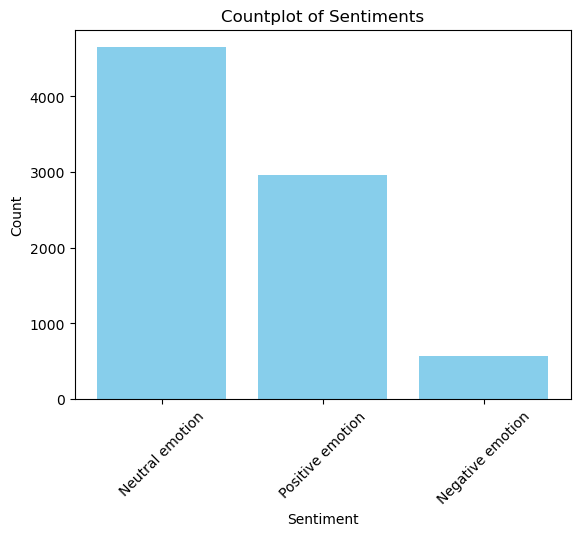

In [18]:
#visualizing the target variable
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Countplot of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 2. Distribution of Brands

In [19]:
counts_1 = df['brand'].value_counts()

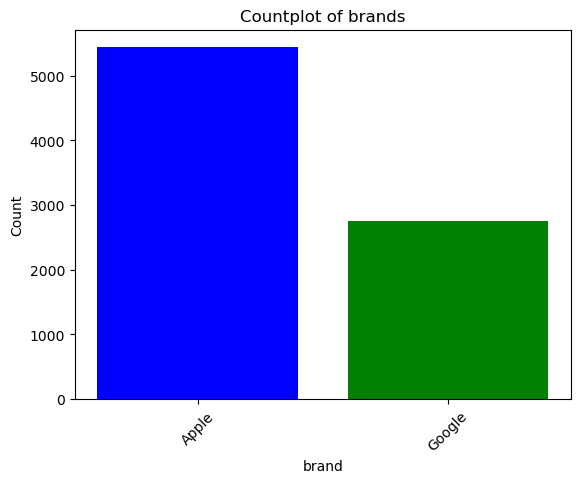

In [20]:
#visualizing the brand column
plt.bar(counts_1.index, counts_1.values, color= ['blue', 'green'])
plt.title('Countplot of brands')
plt.xlabel('brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 3. Distribution of brands according to sentiments

In [ ]:
sentiment_counts = df.groupby(['brand', 'tweet_sentiment']).size().unstack(fill_value=0)
sentiment_counts 

tweet_sentiment  Negative emotion  Neutral emotion  Positive emotion
brand                                                               
Apple                         419             2886              2135
Google                        150             1766               830

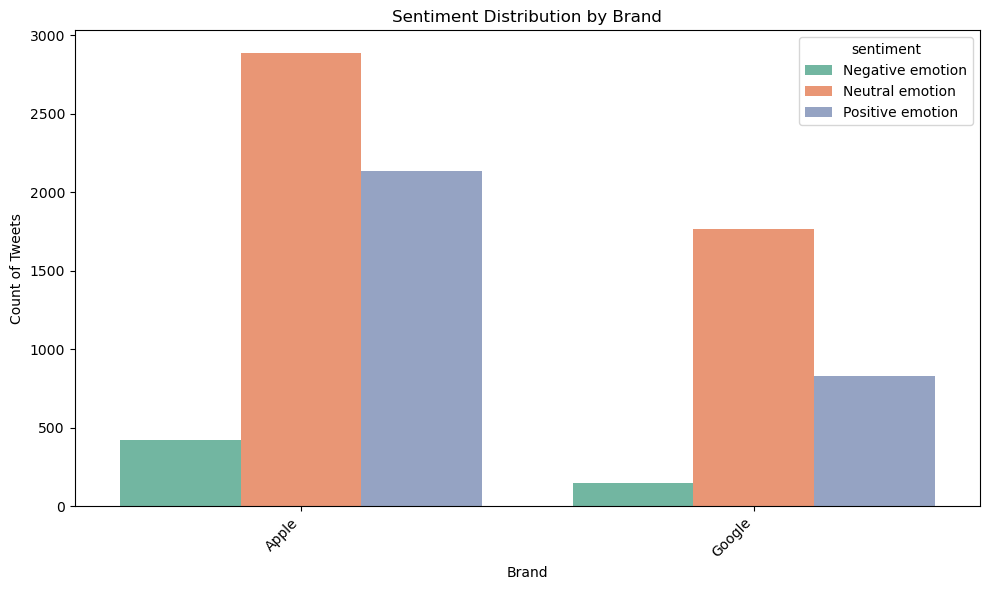

In [22]:

sentiment_counts = sentiment_counts.reset_index()
sentiment_counts_melted = sentiment_counts.melt(id_vars='brand', var_name='sentiment', value_name='count')

plt.figure(figsize=(10, 6))
sns.barplot(x='brand', y='count', hue='sentiment', data=sentiment_counts_melted, palette='Set2')
plt.title('Sentiment Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Count of Tweets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## Text Preprocessing

Prepare the tweet_text column by cleaning and standardizing it to enhance model performance.

### 1.Text Cleaning steps:



    - Converts text to lowercase
    - Removes URLs
    - Removes user mentions 
    - Removes hashtags keeping the text
    - Removes the RT (retweet) symbol
    - Removes numbers
    - Removes punctuation and special characters
    - Removes extra whitespace


In [23]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def preprocess_text(text):

    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions (@)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove RT (retweet) symbol
    text = re.sub(r'\brt\b', '', text)
    
  
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\munga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\munga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\munga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\munga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 2.Text Normalization:

    - Tokenization (splits text into individual words)
    - Stopword removal (removes common words like "the", "is", "at")
    - Lemmatization (reduces words to their base form)

In [24]:
def tokenize_and_lemmatize(text):
   
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

### 3. Apply Preprocessing to Dataset

In [25]:
df_processed = df.copy()

# Apply preprocessing to tweet text
df_processed['processed_text'] = df_processed['tweet_text'].apply(preprocess_text)
df_processed['processed_text'] = df_processed['processed_text'].apply(tokenize_and_lemmatize)

In [26]:
# Display preprocessed texts
print("\nSample of original vs preprocessed texts:")
sample_comparison = pd.DataFrame({
    'Original': df_processed['tweet_text'].head(),
    'Preprocessed': df_processed['processed_text'].head()
})
print(sample_comparison)


Sample of original vs preprocessed texts:
                                            Original  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                        Preprocessed  
0  3g iphone 3 hr tweeting rise_austin dead need ...  
1  know awesome ipadiphone app youll likely appre...  
2                         wait ipad 2 also sale sxsw  
3  hope year festival isnt crashy year iphone app...  
4  great stuff fri sxsw marissa mayer google tim ...  


## Modeling and Evaluation

In [27]:
df_processed.head()

tweet_text   brand  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   Apple   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   Apple   
2  @swonderlin Can not wait for #iPad 2 also. The...   Apple   
3  @sxsw I hope this year's festival isn't as cra...   Apple   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...  Google   

    tweet_sentiment                                     processed_text  
0  Negative emotion  3g iphone 3 hr tweeting rise_austin dead need ...  
1  Positive emotion  know awesome ipadiphone app youll likely appre...  
2  Positive emotion                         wait ipad 2 also sale sxsw  
3  Negative emotion  hope year festival isnt crashy year iphone app...  
4  Positive emotion  great stuff fri sxsw marissa mayer google tim ...

### Investigating tokenized text

In [28]:
corpus = df_processed['processed_text'].tolist()

device  = df_processed['brand'].tolist()



In [29]:
## show distribution of tokenized words according to device

# Tokenize the text

def tokenize_text(text):
    return word_tokenize(text)

tokenized_corpus = [tokenize_text(text) for text in corpus]

zipped_device_data = list(zip(tokenized_corpus, device))

# Group tokens by device

apple_tokens = [tokens for tokens,device in zipped_device_data if device == 'Apple']
google_tokens = [tokens for tokens,device in zipped_device_data if device == 'Google']

# Flattening the list
apple_words = [token for sublist in apple_tokens for token in sublist]
google_words = [token for sublist in google_tokens for token in sublist]

# Generate word clouds for Apple and Google

def generate_wordcloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(Counter(tokens))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()









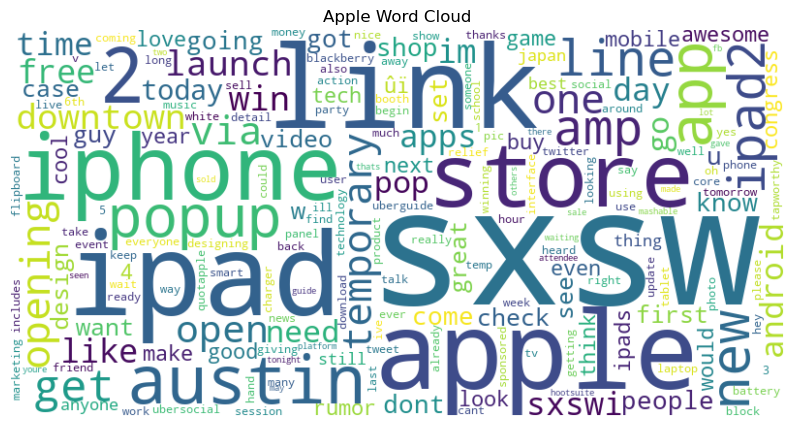

In [30]:
# plotting wordcloud for Apple

generate_wordcloud(apple_words, 'Apple Word Cloud')

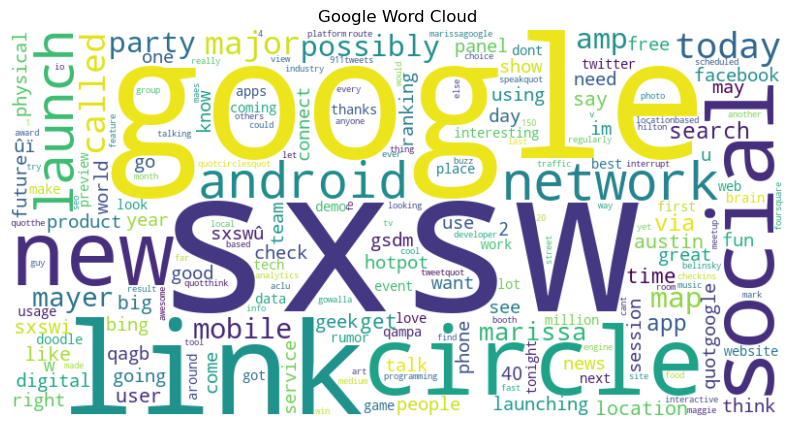

In [31]:
#plotting wordcloud for Google
generate_wordcloud(google_words, 'Google Word Cloud')

In [32]:
# sentiments
sentiments = df_processed['tweet_sentiment'].to_list()
# zipping sentiments with device data
zipped_sentiment_data = list(zip(zipped_device_data,sentiments))

# Group tokens by sentiment and device

apple_positive_content = [tokens for (tokens,device),sentiment in zipped_sentiment_data if device == 'Apple' and sentiment == 'Positive emotion']
apple_negative_content = [tokens for (tokens,device),sentiment in zipped_sentiment_data if device == 'Apple' and sentiment == 'Negative emotion']
apple_neutral_content = [tokens for (tokens,device),sentiment in zipped_sentiment_data if device == 'Apple' and sentiment == 'Neutral emotion']

google_positive_content = [tokens for (tokens,device),sentiment in zipped_sentiment_data if device == 'Google' and sentiment == 'Positive emotion']
google_negative_content = [tokens for (tokens,device),sentiment in zipped_sentiment_data if device == 'Google' and sentiment == 'Negative emotion']
google_neutral_content = [tokens for (tokens,device), sentiment in zipped_sentiment_data if device == "Google" and sentiment == 'Neutral emotion']

# Flatten the list
apple_positive_words = [token for sublist in apple_positive_content for token in sublist]
apple_negative_words = [token for sublist in apple_negative_content for token in sublist]
apple_neutral_words = [token for sublist in apple_neutral_content for token in sublist]

google_positive_words = [token for sublist in google_positive_content for token in sublist]
google_negative_words = [token for sublist in google_negative_content for token in sublist]
google_neutral_words = [token for sublist in google_neutral_content for token in sublist]


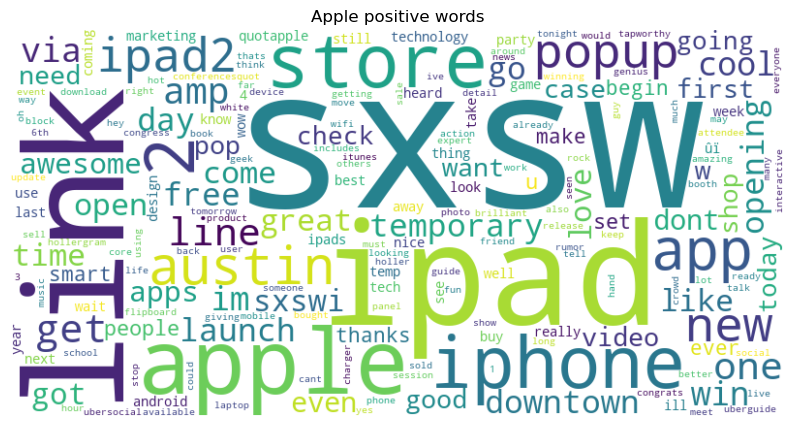

In [33]:
# plotting word distribution of apple positive words

generate_wordcloud(apple_positive_words,"Apple positive words")

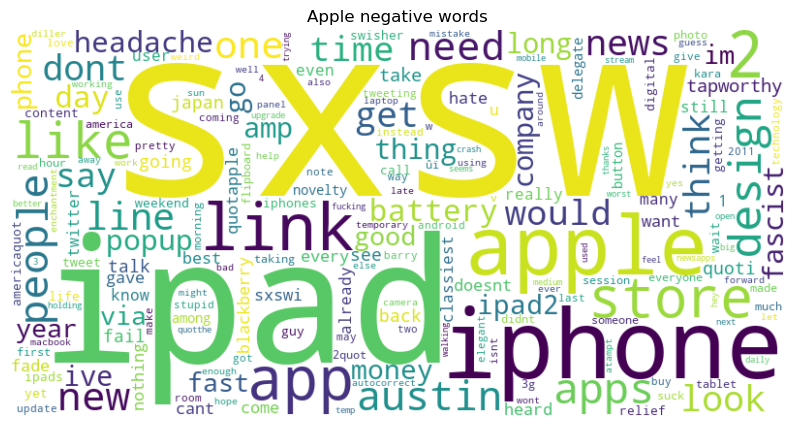

In [34]:
# plotting word distribution of apple negative words
generate_wordcloud(apple_negative_words,"Apple negative words")

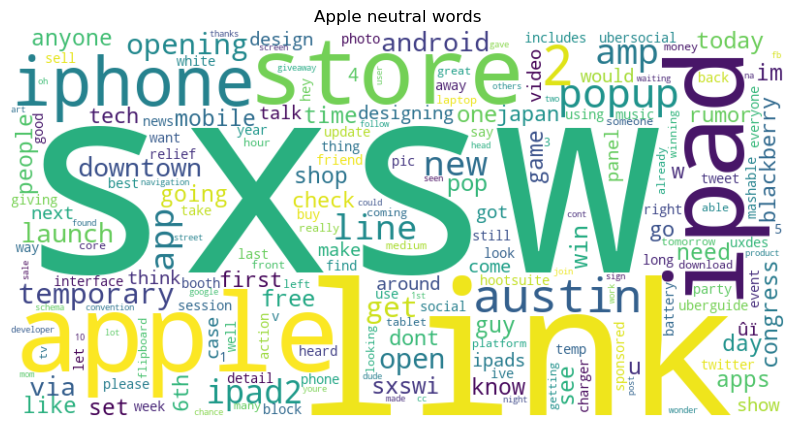

In [35]:
# plotting word distribution of apple neutral words
generate_wordcloud(apple_neutral_words,"Apple neutral words")

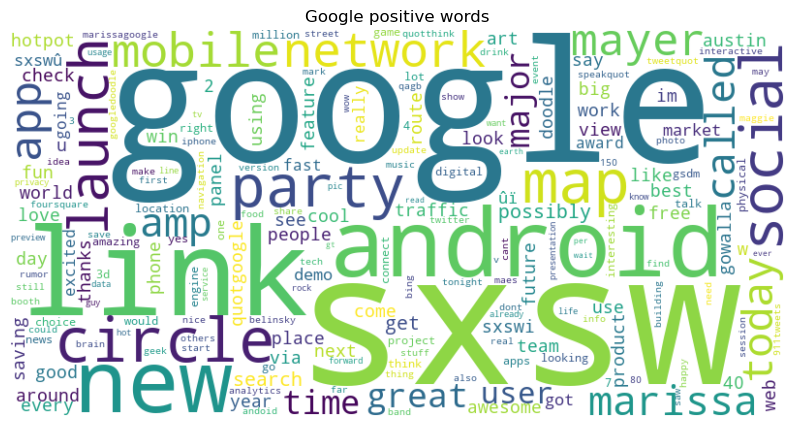

In [36]:
# plotting word distribution of google positive words

generate_wordcloud(google_positive_words, 'Google positive words')

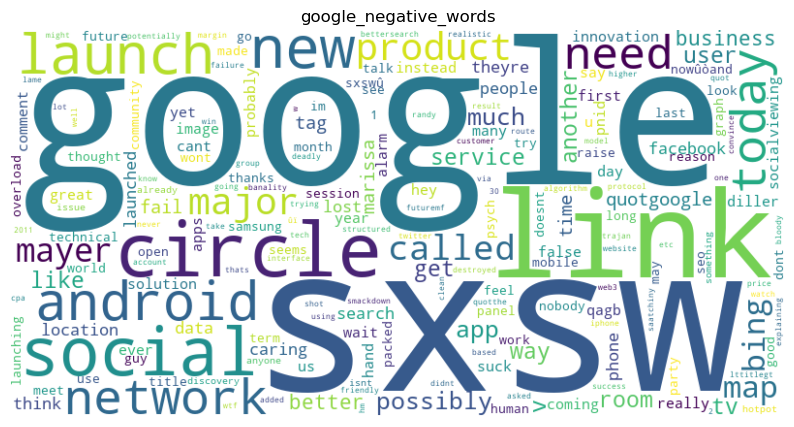

In [37]:
# plotting word distribution of google negative words

generate_wordcloud(google_negative_words, 'google_negative_words')

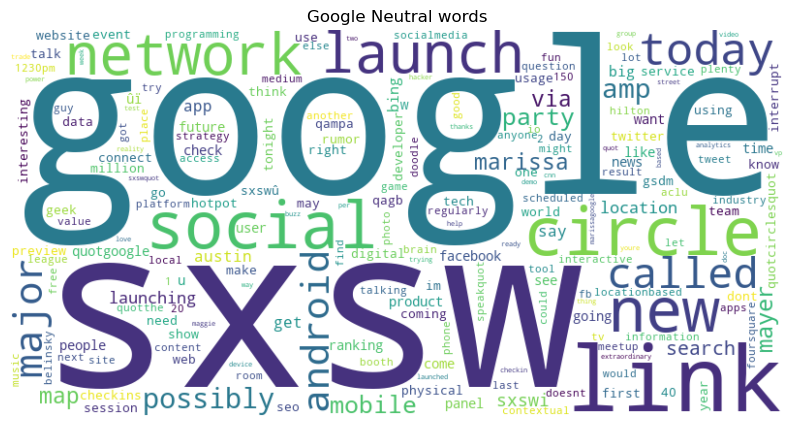

In [38]:
# plotting word distribution of google neutral words

generate_wordcloud(google_neutral_words, 'Google Neutral words')


### Creating function for evaluation

In [39]:
def evaluate_model(model, X_train, X_test, y_train, y_test,classes = None, normalize = 'true', cmap= 'summer', label = ''):
    ' This a function will return a classification report and confusion matrix of the model'
    
    # Retrieve predictions for both training and testing data

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Display classification report for training data
    header = f"{label} Classification Report (Training Data)"
    dashes = '-' * len(header)
    print(f"\n{header}\n{dashes}")
    print(classification_report(y_train, y_pred_train, target_names=classes))

    # Confusion matrix for training data
    cm_train_data = confusion_matrix(y_train, y_pred_train, normalize=normalize, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train_data, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(f"{label} Confusion Matrix (Training Data)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Display classification report for testing data
    header = f"{label} Classification Report (Testing Data)"
    dashes = '-' * len(header)
    print(f"\n{header}\n{dashes}")
    print(classification_report(y_test, y_pred_test, target_names=classes))

    # Confusion matrix for testing data
    cm_test_data = confusion_matrix(y_test, y_pred_test, normalize=normalize,labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test_data, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(f"{label} Confusion Matrix (Testing Data)")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



In [40]:
# Creating a function that creates a dataframe the average f1 score and ROC AUC score of the models

performance_df = pd.DataFrame(columns=['Model', 'Average F1 Score', 'Average ROC AUC Score', 'Standard Deviation of ROC AUC Score'])
def model_performance(pipe, X_train,y_train, label = '', dataframe = performance_df, cv  = 5):
    'This function will perform a cross validation on the model and return the average f1 score and ROC AUC score which will be stored in a dataframe'

    # Cross validation
    cv_f1_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_weighted')
    cv_roc_auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc_ovr_weighted')

    # Average scores
    avg_f1_score = round(cv_f1_scores.mean(), 4)
    avg_roc_auc_score = round(cv_roc_auc_scores.mean(), 4)
    std_roc_auc_score = round(cv_roc_auc_scores.std(), 4)

    # Store the scores in a dataframe
    performance_df.loc[len(dataframe)] = [label, avg_f1_score, avg_roc_auc_score, std_roc_auc_score]



    return performance_df



### Splitting the data

#### binary classification

In [41]:
# Filter the dataset to contain only positive and negative sentiments
df_filtered = df_processed[df_processed['tweet_sentiment'].isin(['Positive emotion', 'Negative emotion'])]
df_filtered= df_filtered[['processed_text', 'tweet_sentiment', 'brand']]

# Split the data into training and testing sets
X = df_filtered.loc[:, ['brand','processed_text']]
y = df_filtered['tweet_sentiment']



X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
count_vectorizer = CountVectorizer(tokenizer=word_tokenize)
X_train_count = count_vectorizer.fit_transform(X_train_binary['processed_text'])
X_test_count = count_vectorizer.transform(X_test_binary['processed_text'])

#vectorize the text data using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_binary['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test_binary['processed_text'])



#One hot encoding the brand column
X_train_brand = pd.get_dummies(X_train_binary['brand'],drop_first= True).values
X_test_brand = pd.get_dummies(X_test_binary['brand'],drop_first= True).values

print(f"X_train_count shape: {X_train_count.shape}")
print(f"X_train_brand shape: {X_train_brand.shape}")
print(f"X_test_count shape: {X_test_count.shape}")
print(f"X_test_brand shape: {X_test_brand.shape}")

X_brand_train_sparse = sp.csr_matrix(X_train_brand)
X_brand_test_sparse = sp.csr_matrix(X_test_brand)

# Combine the text_count data with the brand data
X_train_binary_count_combined = sp.hstack((X_train_count, X_brand_train_sparse))
X_test_binary_count_combined = sp.hstack((X_test_count, X_brand_test_sparse))


# Combine the text_tfidf data with the brand data
X_train_binary_tfidf_combined = sp.hstack((X_train_tfidf, sp.csr_matrix(X_train_brand)))
X_test_binary_tfidf_combined = sp.hstack((X_test_tfidf, sp.csr_matrix(X_test_brand)))




X_train_count shape: (2827, 5359)
X_train_brand shape: (2827, 1)
X_test_count shape: (707, 5359)
X_test_brand shape: (707, 1)


#### Multinomial classification

In [42]:
# Declaring X and y variables

X = df_processed.loc[:, ['brand','processed_text']]
y = df_processed['tweet_sentiment']

y.value_counts()

tweet_sentiment
Neutral emotion     4652
Positive emotion    2965
Negative emotion     569
Name: count, dtype: int64

In [43]:
# splitting the data into training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
# Vectorize the text data using TF-IDF

tf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
X_train_text_tfidf = tf_vectorizer.fit_transform(X_train['processed_text'])
X_test_text_tfidf = tf_vectorizer.transform(X_test['processed_text'])

In [45]:
# Vectorize the text data using CountVectorizer

Count_vectorizer = CountVectorizer(tokenizer=word_tokenize)

X_train_text_count = Count_vectorizer.fit_transform(X_train['processed_text'])
X_test_text_count = Count_vectorizer.transform(X_test['processed_text'])

In [46]:
# One-hot encode the brand column

X_train_brand = pd.get_dummies(X_train['brand'], drop_first=True)
X_test_brand = pd.get_dummies(X_test['brand'], drop_first=True)

# Convert the brand data to sparse matrix

X_train_brand_sparse = sp.csr_matrix(X_train_brand)
X_test_brand_sparse = sp.csr_matrix(X_test_brand)

# Combine the text_count data with the brand data

X_train_multinomial_count_combined = sp.hstack((X_train_text_count, X_train_brand_sparse))
X_test_multinomial_count_combined = sp.hstack((X_test_text_count, X_test_brand_sparse))

# Combine the text_tfidf data with the brand data
X_train_multinomial_tfidf_combined = sp.hstack((X_train_text_tfidf, X_train_brand_sparse))
X_test_multinomial_tfidf_combined = sp.hstack((X_test_text_tfidf, X_test_brand_sparse))


### Models to be used:

- Logistic Regression
- Random Forest
- Multinomial Naive Bayes
- Support Vector Machine


#### Logistic Regression


##### Base model (Binary Classification)

Let's start by building a base model using Logistic Regression for binary classification (positive and negative sentiments).This will help us establish how well our model performs in predicting whether a sentiment is positive or negative.



In [47]:
X_train_binary_count_combined.shape

(2827, 5360)


Logistic Regression Count Vectorizer Classification Report (Training Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.99      0.84      0.91       466
Negative emotion       0.97      1.00      0.98      2361

        accuracy                           0.97      2827
       macro avg       0.98      0.92      0.95      2827
    weighted avg       0.97      0.97      0.97      2827



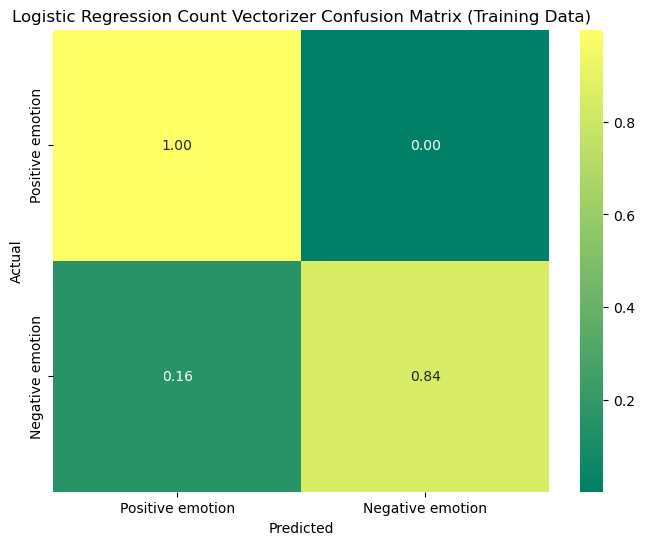


Logistic Regression Count Vectorizer Classification Report (Testing Data)
-------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.80      0.39      0.52       103
Negative emotion       0.90      0.98      0.94       604

        accuracy                           0.90       707
       macro avg       0.85      0.69      0.73       707
    weighted avg       0.89      0.90      0.88       707



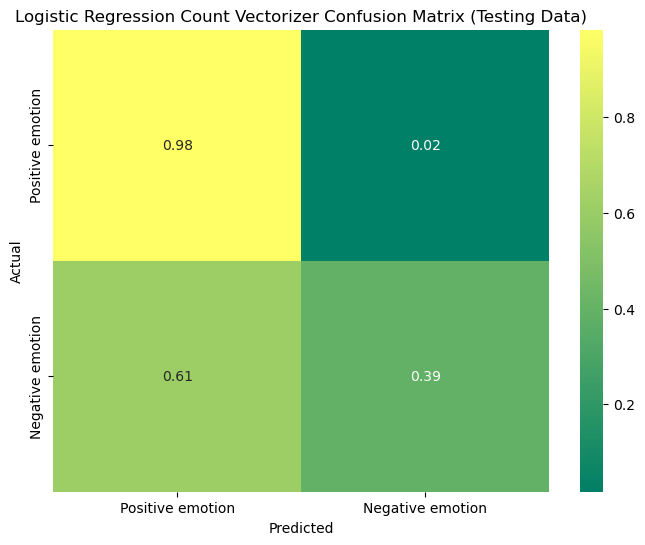

In [48]:
Logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data

Logreg.fit(X_train_binary_count_combined, y_train_binary)

# Evaluate the model
evaluate_model(Logreg, X_train_binary_count_combined, X_test_binary_count_combined, y_train_binary, y_test_binary, classes=['Positive emotion', 'Negative emotion'], label='Logistic Regression Count Vectorizer')



###### TF-IDF Vectorizer


Logistic Regression TF-IDF Vectorizer Classification Report (Training Data)
---------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.99      0.14      0.25       466
Negative emotion       0.86      1.00      0.92      2361

        accuracy                           0.86      2827
       macro avg       0.92      0.57      0.58      2827
    weighted avg       0.88      0.86      0.81      2827



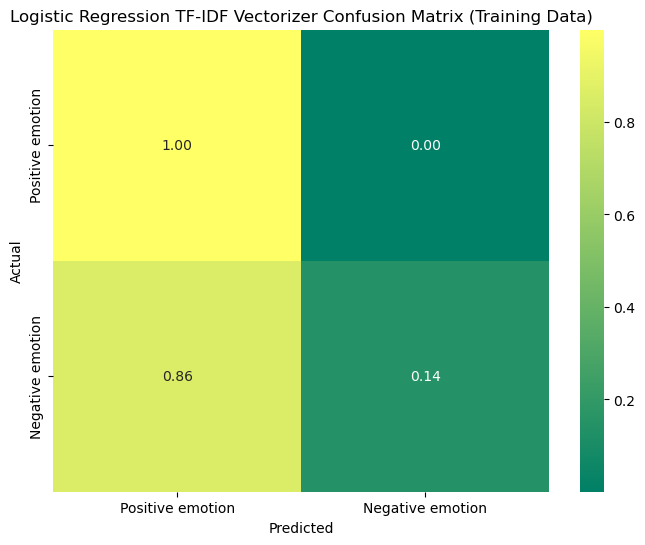


Logistic Regression TF-IDF Vectorizer Classification Report (Testing Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       1.00      0.05      0.09       103
Negative emotion       0.86      1.00      0.92       604

        accuracy                           0.86       707
       macro avg       0.93      0.52      0.51       707
    weighted avg       0.88      0.86      0.80       707



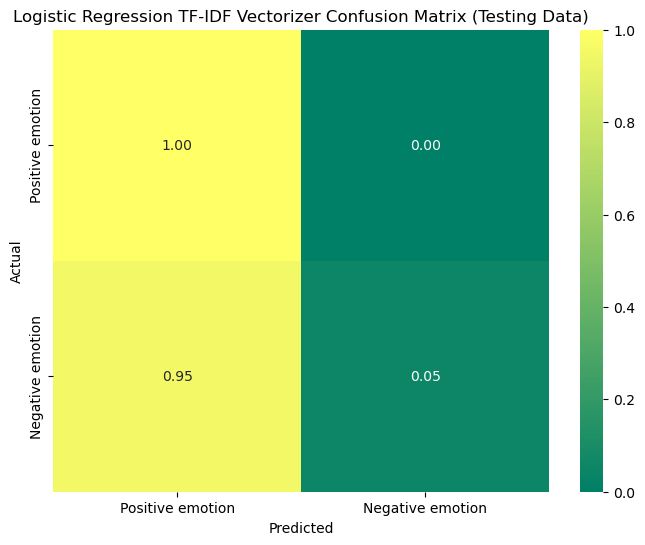

In [49]:
Logreg = LogisticRegression(max_iter=1000,random_state=42)

# Fit the model on the training data

Logreg.fit(X_train_binary_tfidf_combined, y_train_binary)

# Evaluate the model
evaluate_model(Logreg, X_train_binary_tfidf_combined, X_test_binary_tfidf_combined, y_train_binary, y_test_binary, classes=['Positive emotion', 'Negative emotion'], label='Logistic Regression TF-IDF Vectorizer')

We can see that the model is performing badly in predicting negative sentiment. This is due to the class imbalance in the dataset.

##### Base model (Multinomial Classification)


Logistic Regression Count Vectorizer Classification Report (Training Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.98      0.77      0.86       455
 Neutral emotion       0.89      0.96      0.92      3721
Negative emotion       0.93      0.85      0.89      2372

        accuracy                           0.91      6548
       macro avg       0.93      0.86      0.89      6548
    weighted avg       0.91      0.91      0.91      6548



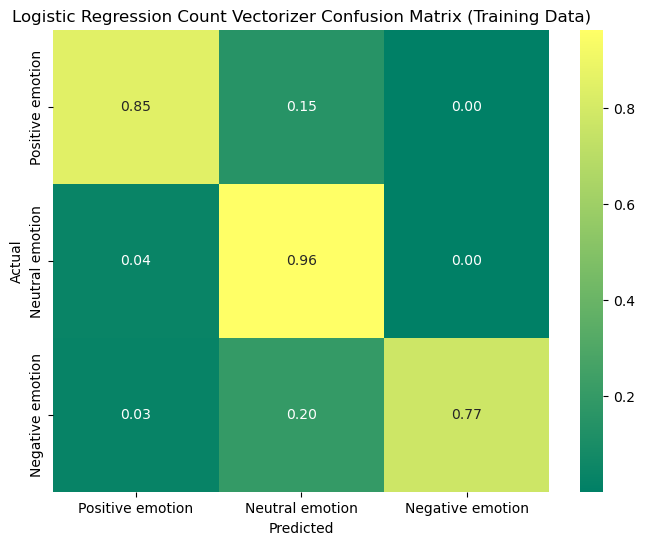


Logistic Regression Count Vectorizer Classification Report (Testing Data)
-------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.60      0.27      0.37       114
 Neutral emotion       0.70      0.79      0.74       931
Negative emotion       0.62      0.57      0.59       593

        accuracy                           0.67      1638
       macro avg       0.64      0.54      0.57      1638
    weighted avg       0.66      0.67      0.66      1638



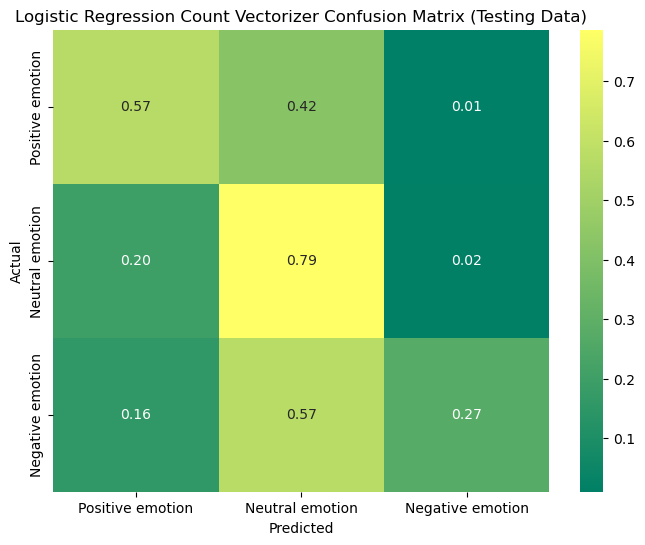

In [50]:
Logreg = LogisticRegression(max_iter=1000,multi_class='multinomial',random_state=42)

# Fit the model on the training data
Logreg.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model
evaluate_model(Logreg, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test,classes= ['Positive emotion','Neutral emotion','Negative emotion'],label='Logistic Regression Count Vectorizer')


Logistic Regression TF-IDF Vectorizer Classification Report (Training Data)
---------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.96      0.22      0.35       455
 Neutral emotion       0.79      0.95      0.87      3721
Negative emotion       0.87      0.73      0.79      2372

        accuracy                           0.82      6548
       macro avg       0.87      0.63      0.67      6548
    weighted avg       0.83      0.82      0.80      6548



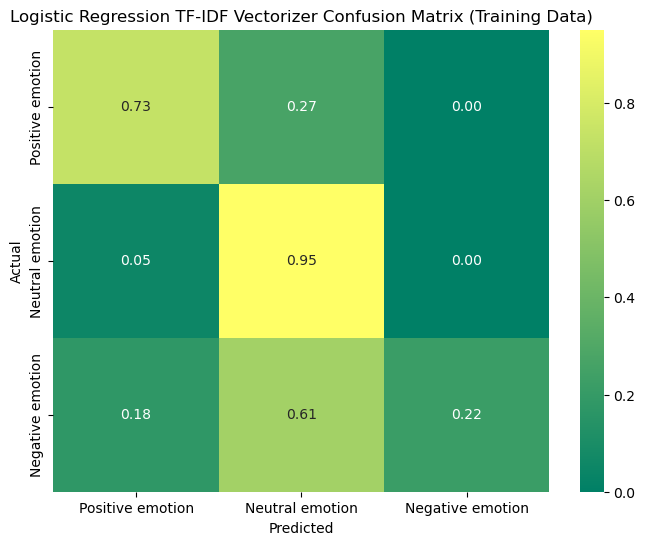


Logistic Regression TF-IDF Vectorizer Classification Report (Testing Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.73      0.10      0.17       114
 Neutral emotion       0.68      0.84      0.75       931
Negative emotion       0.64      0.51      0.57       593

        accuracy                           0.67      1638
       macro avg       0.68      0.48      0.50      1638
    weighted avg       0.67      0.67      0.64      1638



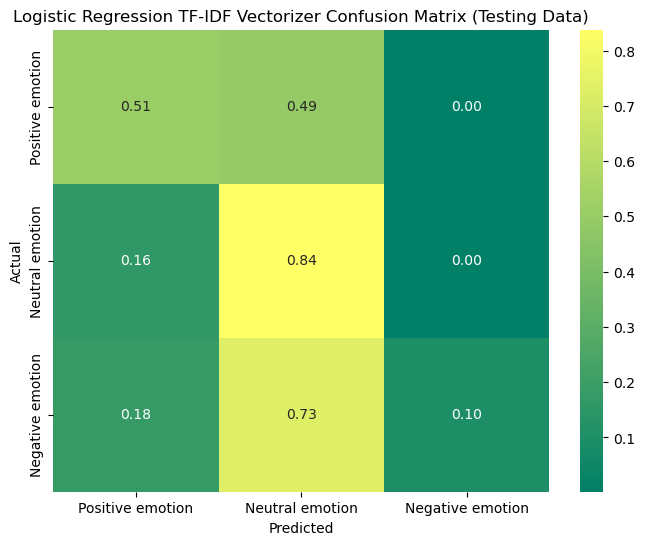

In [51]:
Logreg = LogisticRegression(max_iter=1000,multi_class='multinomial',random_state=42)

# Fit the model on the training data
Logreg.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model
evaluate_model(Logreg, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test,classes= ['Positive emotion','Neutral emotion','Negative emotion'],label='Logistic Regression TF-IDF Vectorizer')

 In this case, we built a base model using Logistic Regression for multinomial classification (positive, negative, and neutral sentiments). Using any of the different vectorizers, we can see that the model has very poor recall score. This is due to the class imbalance in the dataset.

##### Logistic Regression,Count Vectorizer with balanced class weights


Logistic Regression Count Vectorizer Classification Report (Training Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.79      1.00      0.88       455
 Neutral emotion       0.94      0.89      0.91      3721
Negative emotion       0.87      0.90      0.88      2372

        accuracy                           0.90      6548
       macro avg       0.87      0.93      0.89      6548
    weighted avg       0.90      0.90      0.90      6548



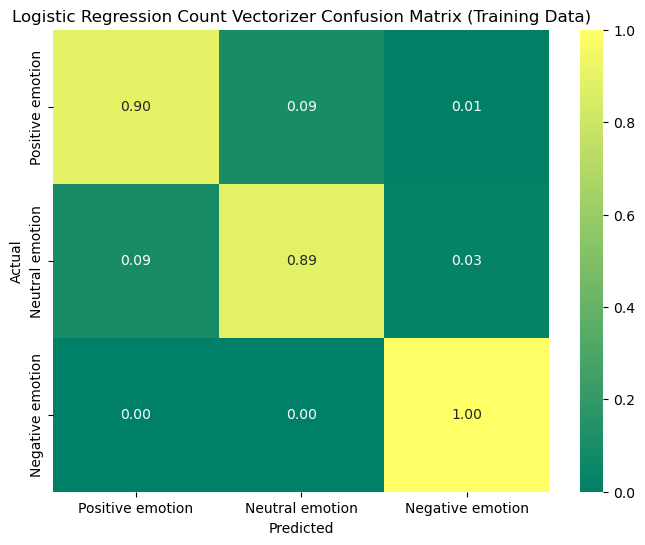


Logistic Regression Count Vectorizer Classification Report (Testing Data)
-------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.43      0.53      0.47       114
 Neutral emotion       0.72      0.69      0.71       931
Negative emotion       0.60      0.62      0.61       593

        accuracy                           0.65      1638
       macro avg       0.59      0.61      0.60      1638
    weighted avg       0.66      0.65      0.66      1638



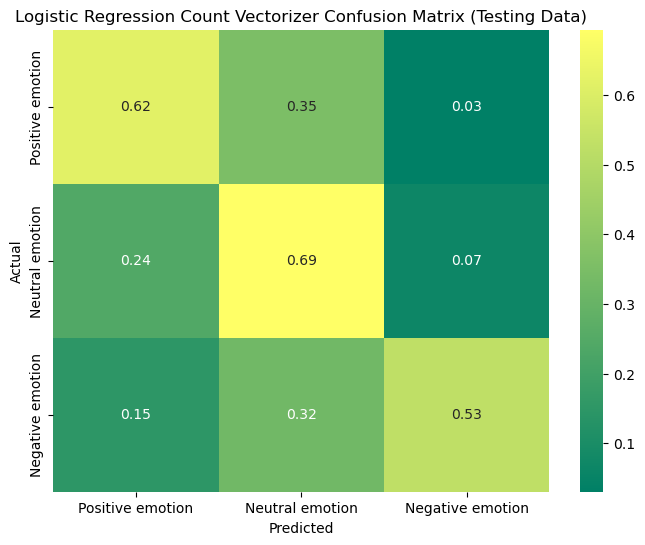

In [52]:
Logreg = LogisticRegression(max_iter=1000,multi_class='multinomial',class_weight='balanced', random_state= 42)

# Fit the model on the training data
Logreg.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model
evaluate_model(Logreg, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test,classes= ['Positive emotion','Neutral emotion','Negative emotion'],label='Logistic Regression Count Vectorizer')


##### Logistic Regression,TF-IDF Vectorizer with balanced class weights


Logistic Regression TF-IDF Vectorizer Classification Report (Training Data)
---------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.62      0.99      0.76       455
 Neutral emotion       0.89      0.81      0.85      3721
Negative emotion       0.80      0.82      0.81      2372

        accuracy                           0.83      6548
       macro avg       0.77      0.87      0.81      6548
    weighted avg       0.84      0.83      0.83      6548



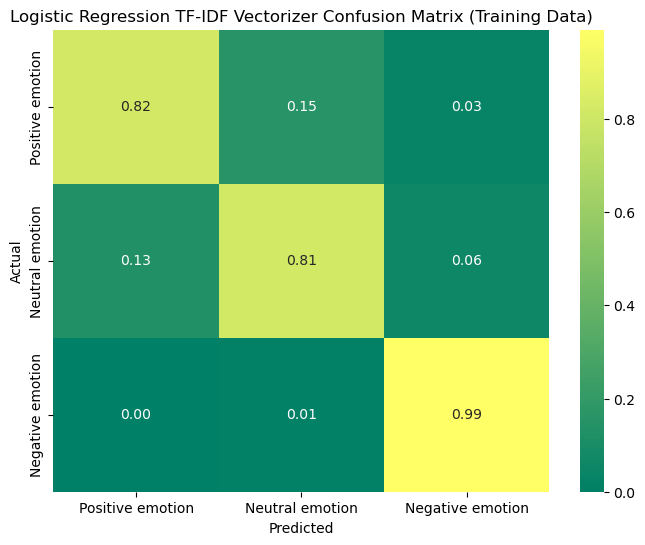


Logistic Regression TF-IDF Vectorizer Classification Report (Testing Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.33      0.52      0.41       114
 Neutral emotion       0.73      0.67      0.70       931
Negative emotion       0.60      0.61      0.61       593

        accuracy                           0.64      1638
       macro avg       0.55      0.60      0.57      1638
    weighted avg       0.65      0.64      0.64      1638



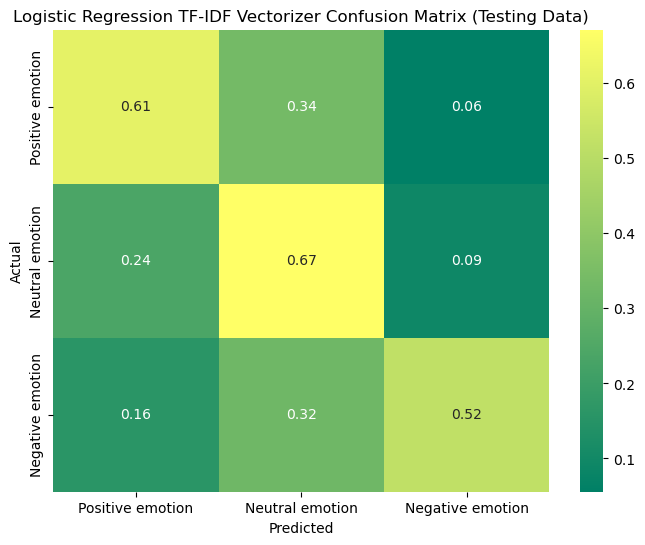

In [53]:
Logreg = LogisticRegression(max_iter=1000,multi_class='multinomial',class_weight='balanced', random_state= 42)

# Fit the model on the training data
Logreg.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model
evaluate_model(Logreg, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test,classes= ['Positive emotion','Neutral emotion','Negative emotion'],label='Logistic Regression TF-IDF Vectorizer')

Using the balanced class weights, we can see that the model recall values increase but the precision values decrease. This is due to the fact that the model is now predicting more false positives.

##### Logistic Regression,Count Vectorizer with SMOTE



Logistic Regression Count Vectorizer (SMOTE) Classification Report (Training Data)
----------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.97      0.97      0.97      3721
 Neutral emotion       0.93      0.90      0.91      3721
Negative emotion       0.87      0.91      0.89      2372

        accuracy                           0.93      9814
       macro avg       0.92      0.93      0.92      9814
    weighted avg       0.93      0.93      0.93      9814



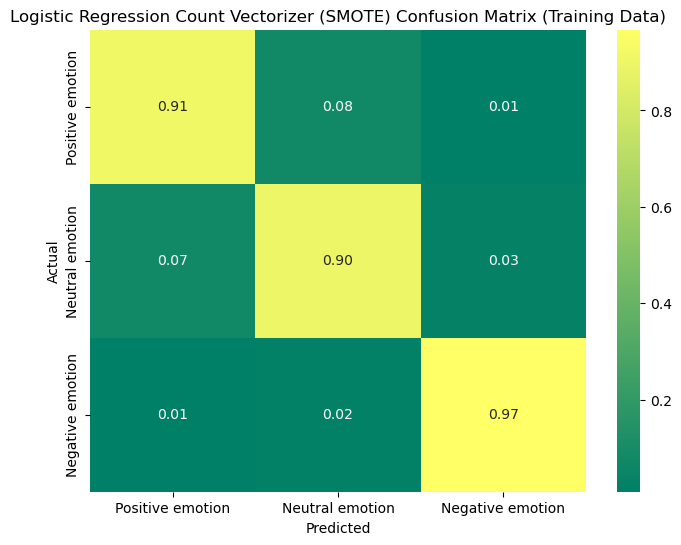


Logistic Regression Count Vectorizer (SMOTE) Classification Report (Testing Data)
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.25      0.42      0.31       114
 Neutral emotion       0.71      0.66      0.69       931
Negative emotion       0.61      0.60      0.60       593

        accuracy                           0.62      1638
       macro avg       0.52      0.56      0.53      1638
    weighted avg       0.64      0.62      0.63      1638



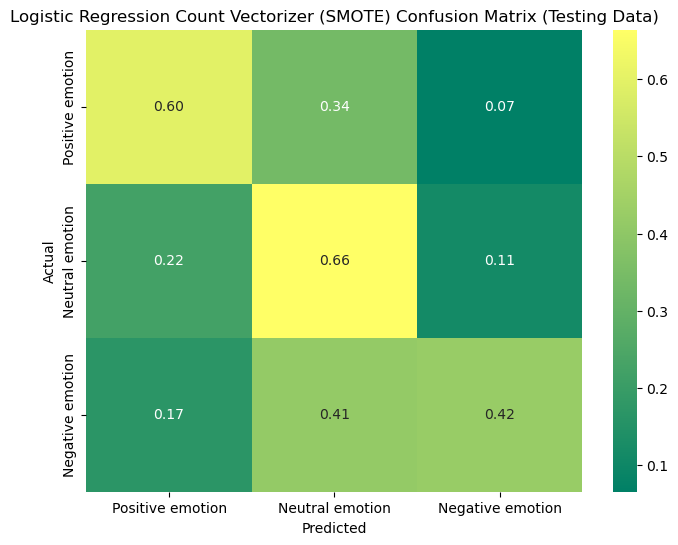

In [54]:
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_count_combined, y_train)

Logreg = LogisticRegression(max_iter=1000,multi_class='multinomial',class_weight='balanced', random_state= 42)

# Fit the model on the resampled training data
Logreg.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(Logreg, X_train_resampled, X_test_multinomial_count_combined, y_train_resampled, y_test,classes= ['Positive emotion','Neutral emotion','Negative emotion'],label='Logistic Regression Count Vectorizer (SMOTE)')


##### Logistic Regression,TF-IDF Vectorizer with SMOTE


Logistic Regression TF-IDF Vectorizer (SMOTE) Classification Report (Training Data)
-----------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.95      1.00      0.97      3721
 Neutral emotion       0.91      0.84      0.87      3721
Negative emotion       0.82      0.85      0.84      2372

        accuracy                           0.90      9814
       macro avg       0.89      0.90      0.89      9814
    weighted avg       0.90      0.90      0.90      9814



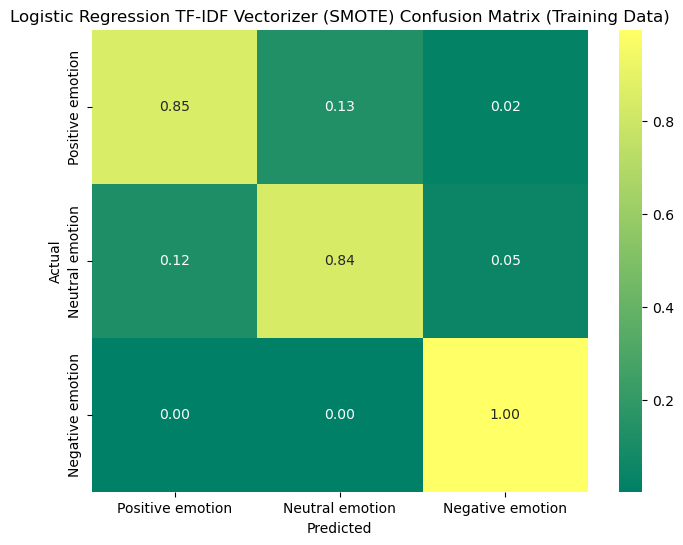


Logistic Regression TF-IDF Vectorizer (SMOTE) Classification Report (Testing Data)
----------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.37      0.50      0.43       114
 Neutral emotion       0.73      0.68      0.70       931
Negative emotion       0.59      0.61      0.60       593

        accuracy                           0.64      1638
       macro avg       0.56      0.60      0.58      1638
    weighted avg       0.65      0.64      0.65      1638



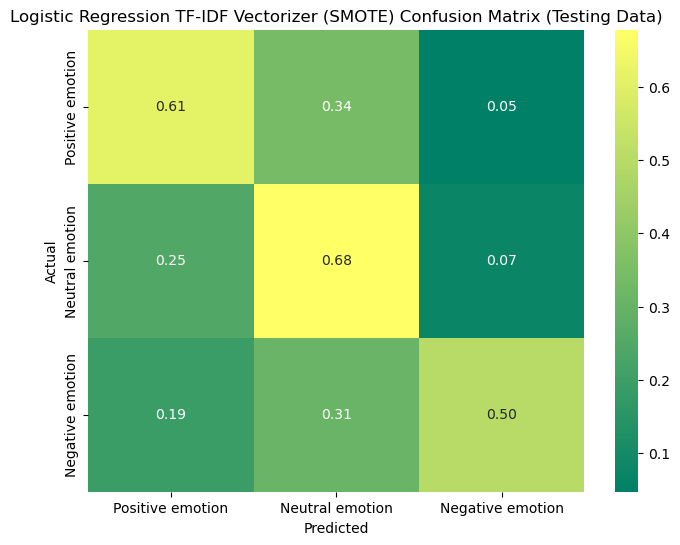

In [55]:
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_tfidf_combined, y_train)

Logreg = LogisticRegression(max_iter=1000,multi_class='multinomial',class_weight='balanced', random_state= 42)

# Fit the model on the resampled training data
Logreg.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(Logreg, X_train_resampled, X_test_multinomial_tfidf_combined, y_train_resampled, y_test,classes= ['Positive emotion','Neutral emotion','Negative emotion'],label='Logistic Regression TF-IDF Vectorizer (SMOTE)')

Using SMOTE, we can see that using the training set the model is performing very well while on the test set the model is performing poorly. This is due to the fact that the model is overfitting on the training set.

##### Logistic Regression,GRID SEARCH with either Count Vectorizer or TF-IDF Vectorizer

In [56]:
# Create a pipeline for Logistic Regression with Count Vectorizer

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', random_state=42))
])


# Define the hyperparameters to tune
param_grid = {
    'smote__sampling_strategy': ['minority', 'not minority'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['newton-cg', 'lbfgs','saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train_multinomial_count_combined, y_train)

# Display the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters: {'model__C': 1, 'model__solver': 'saga', 'smote__sampling_strategy': 'not minority'}
Best F1 Score: 0.5466702519565644



Logistic Regression Count Vectorizer (SMOTE) Classification Report (Training Data)
----------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.96      0.97      0.97      3721
 Neutral emotion       0.92      0.89      0.91      3721
Negative emotion       0.87      0.91      0.89      2372

        accuracy                           0.93      9814
       macro avg       0.92      0.92      0.92      9814
    weighted avg       0.93      0.93      0.93      9814



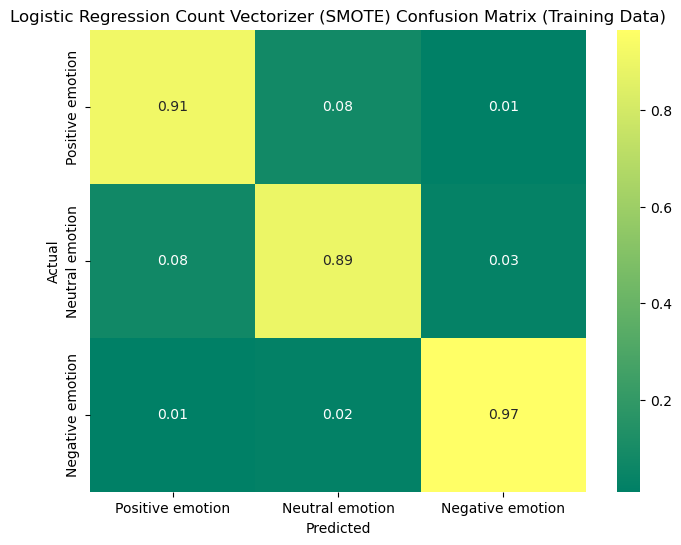


Logistic Regression Count Vectorizer (SMOTE) Classification Report (Testing Data)
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.25      0.43      0.32       114
 Neutral emotion       0.72      0.66      0.69       931
Negative emotion       0.61      0.60      0.61       593

        accuracy                           0.62      1638
       macro avg       0.53      0.56      0.54      1638
    weighted avg       0.65      0.62      0.63      1638



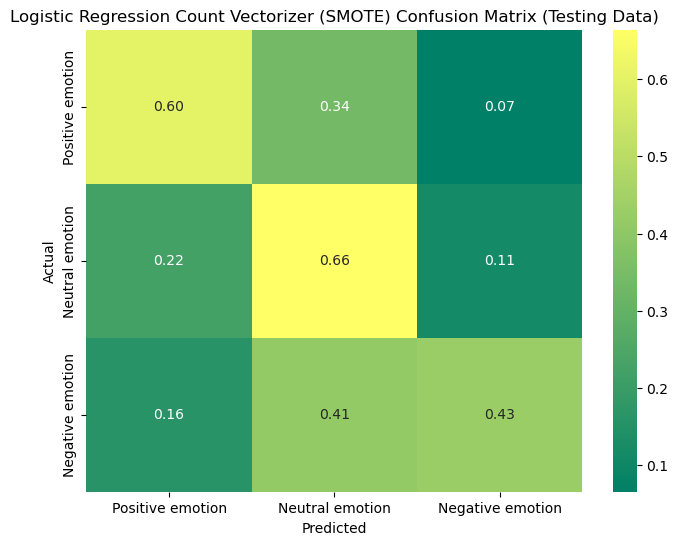

In [57]:
logreg =LogisticRegression(C=1, class_weight='balanced', max_iter=1000, multi_class='multinomial', random_state=42, solver='newton-cg')

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_count_combined, y_train)

# Fit the model on the resampled training data
logreg.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
evaluate_model(logreg, X_train_resampled, X_test_multinomial_count_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Logistic Regression Count Vectorizer (SMOTE)')


In [58]:
# Create a pipeline for Logistic Regression with TF-IDF Vectorizer

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', random_state=42))
])

# Define the hyperparameters to tune
param_grid = {
    'smote__sampling_strategy': ['minority', 'not minority'],
    'model__C': [0.1, 1, 10],
    'model__solver': ['newton-cg', 'lbfgs','saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train_multinomial_tfidf_combined, y_train)

# Display the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters: {'model__C': 1, 'model__solver': 'lbfgs', 'smote__sampling_strategy': 'minority'}
Best F1 Score: 0.568523377770852



Logistic Regression TF-IDF Vectorizer (SMOTE) Classification Report (Training Data)
-----------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.95      1.00      0.97      3721
 Neutral emotion       0.91      0.84      0.87      3721
Negative emotion       0.82      0.85      0.84      2372

        accuracy                           0.90      9814
       macro avg       0.89      0.90      0.89      9814
    weighted avg       0.90      0.90      0.90      9814



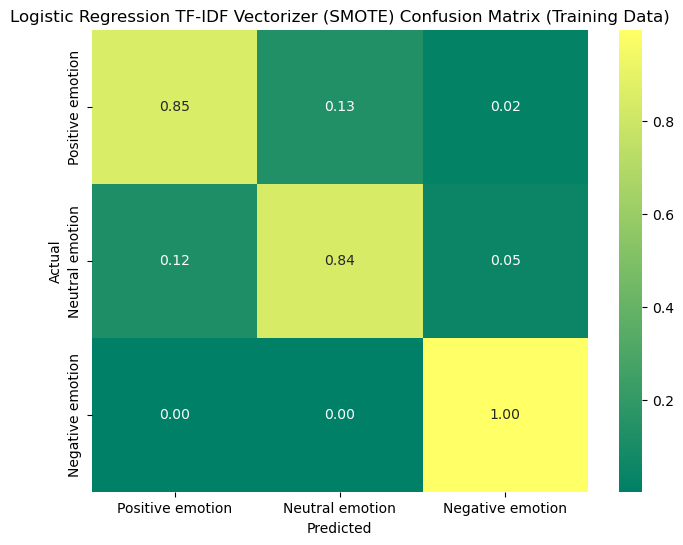


Logistic Regression TF-IDF Vectorizer (SMOTE) Classification Report (Testing Data)
----------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.37      0.50      0.43       114
 Neutral emotion       0.73      0.68      0.70       931
Negative emotion       0.59      0.61      0.60       593

        accuracy                           0.64      1638
       macro avg       0.56      0.60      0.58      1638
    weighted avg       0.65      0.64      0.65      1638



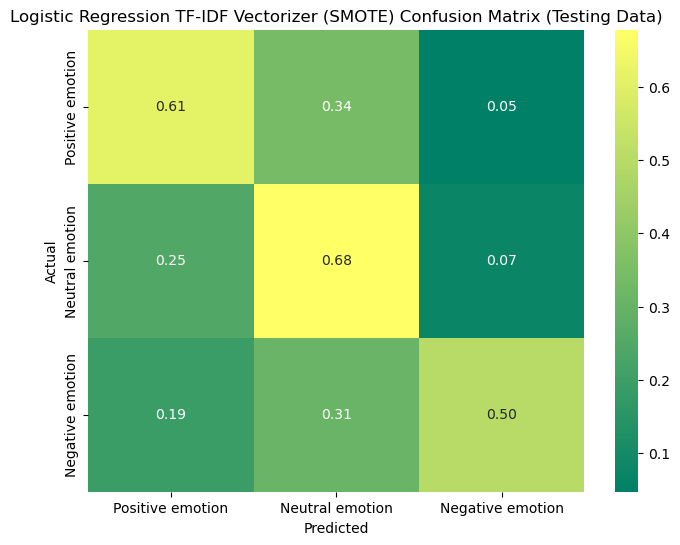

In [59]:
Logreg = LogisticRegression(C=1, class_weight='balanced', max_iter=1000, multi_class='multinomial', random_state=42, solver='lbfgs')

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_tfidf_combined, y_train)

# Fit the model on the resampled training data

Logreg.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(Logreg, X_train_resampled, X_test_multinomial_tfidf_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Logistic Regression TF-IDF Vectorizer (SMOTE)')


Using Grid Search, we can see that the model is performing well on the training set but performs relatively the same on the test set with added parameters.This indicates that there is no much improvement in the model performance with the added parameters.

##### Best LogReg model

In [60]:
# calling the model performance to store the average f1 score and ROC AUC score of the best performing Logistic Regression Model

logreg_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('model', LogisticRegression(C=1, class_weight='balanced', max_iter=1000, multi_class='multinomial', random_state=42, solver='lbfgs'))
])

model_performance(logreg_pipeline, X_train_multinomial_tfidf_combined, y_train, label='Logistic Regression TF-IDF Vectorizer (SMOTE)')



Model  Average F1 Score  \
0  Logistic Regression TF-IDF Vectorizer (SMOTE)            0.6512   

   Average ROC AUC Score  Standard Deviation of ROC AUC Score  
0                 0.7519                               0.0064

####  NAIVE BAYES

##### Multinomial Naive Bayes,Count Vectorizer


Naive Bayes Count Vectorizer Classification Report (Training Data)
------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.87      0.47      0.61       455
 Neutral emotion       0.83      0.90      0.86      3721
Negative emotion       0.80      0.77      0.79      2372

        accuracy                           0.82      6548
       macro avg       0.83      0.71      0.75      6548
    weighted avg       0.82      0.82      0.82      6548



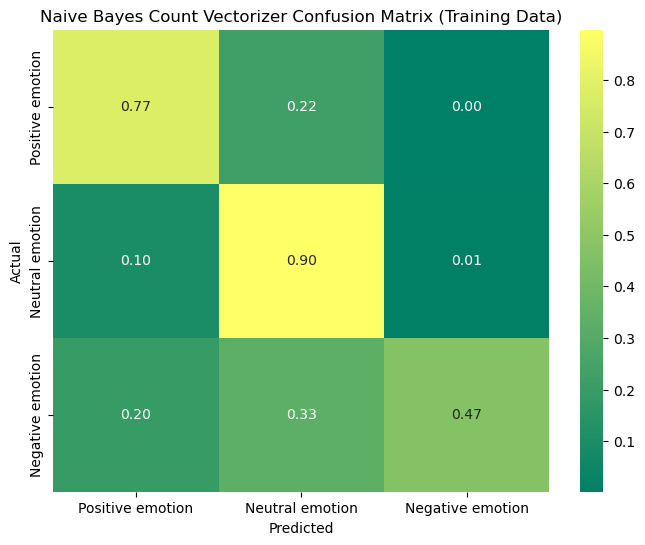


Naive Bayes Count Vectorizer Classification Report (Testing Data)
-----------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.61      0.17      0.26       114
 Neutral emotion       0.69      0.76      0.72       931
Negative emotion       0.58      0.56      0.57       593

        accuracy                           0.65      1638
       macro avg       0.63      0.50      0.52      1638
    weighted avg       0.64      0.65      0.64      1638



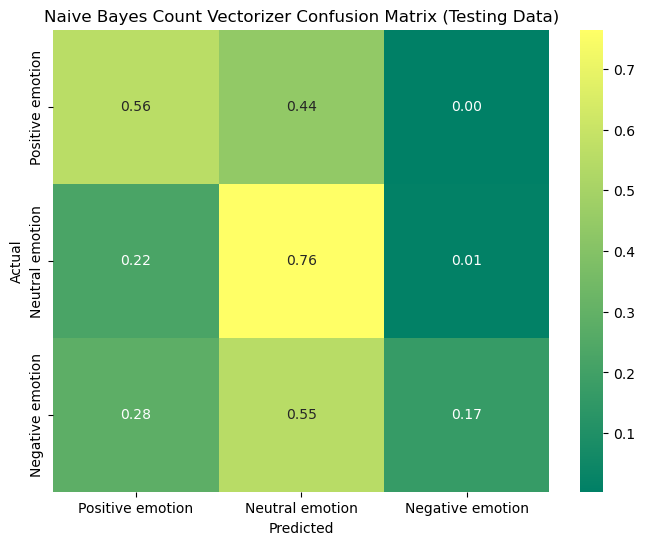

In [61]:
# Usung CountVectorizer to vectorize the text data
nb_model = MultinomialNB()

# Fit the model on the training data    
nb_model.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model
evaluate_model(nb_model, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes Count Vectorizer')

The model has improved on accuracy score to the Logistic Regression model but the recall score is still very low especially for the positive sentiment.The model seems to biased towards the neutral sentiment.

##### Multinomial Naive Bayes,TF-IDF Vectorizer


Naive Bayes TF-IDF Vectorizer Classification Report (Training Data)
-------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.95      0.05      0.09       455
 Neutral emotion       0.72      0.97      0.83      3721
Negative emotion       0.88      0.56      0.68      2372

        accuracy                           0.76      6548
       macro avg       0.85      0.53      0.53      6548
    weighted avg       0.80      0.76      0.73      6548



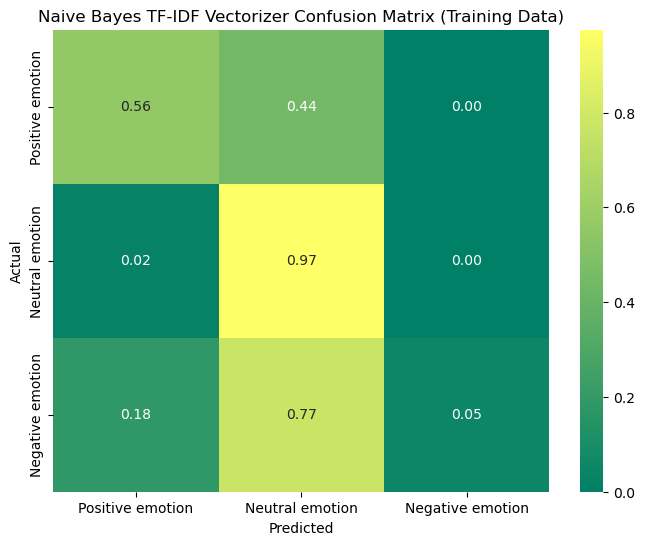


Naive Bayes TF-IDF Vectorizer Classification Report (Testing Data)
------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       1.00      0.02      0.03       114
 Neutral emotion       0.63      0.91      0.75       931
Negative emotion       0.68      0.33      0.44       593

        accuracy                           0.64      1638
       macro avg       0.77      0.42      0.41      1638
    weighted avg       0.67      0.64      0.59      1638



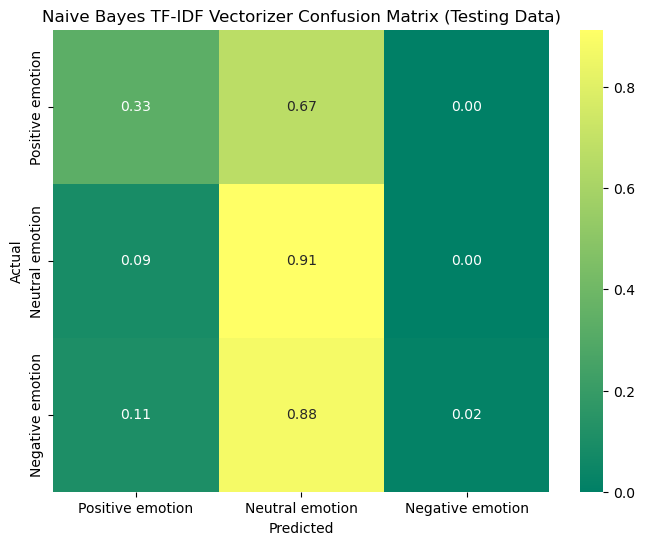

In [62]:
# Using TF-IDF Vectorizer

nb_model = MultinomialNB()

# Fit the model on the training data

nb_model.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(nb_model, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes TF-IDF Vectorizer')

The model seems to be biased towards the neutral sentiment.

In [63]:
y.value_counts()

tweet_sentiment
Neutral emotion     4652
Positive emotion    2965
Negative emotion     569
Name: count, dtype: int64

##### Multinomial Naive Bayes,with class prior weights,count vectorizer


Naive Bayes Count Vectorizer Classification Report (Training Data)
------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.59      0.67      0.63       455
 Neutral emotion       0.76      0.94      0.84      3721
Negative emotion       0.94      0.55      0.69      2372

        accuracy                           0.78      6548
       macro avg       0.76      0.72      0.72      6548
    weighted avg       0.81      0.78      0.77      6548



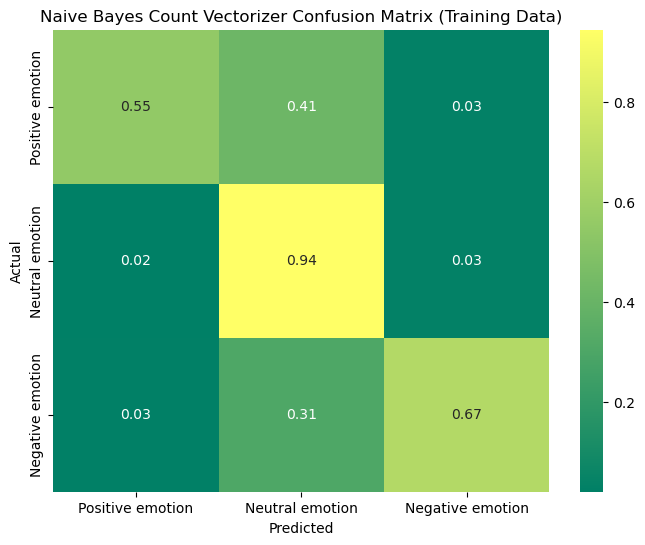


Naive Bayes Count Vectorizer Classification Report (Testing Data)
-----------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.35      0.32      0.33       114
 Neutral emotion       0.65      0.87      0.74       931
Negative emotion       0.72      0.33      0.46       593

        accuracy                           0.64      1638
       macro avg       0.57      0.51      0.51      1638
    weighted avg       0.65      0.64      0.61      1638



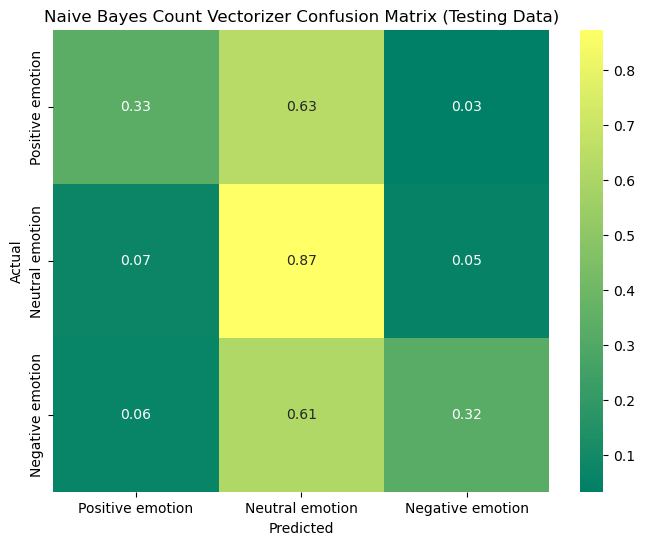

In [64]:
# Trial with a class prior
# Using Count Vectorizer

nb_model = MultinomialNB(class_prior=[0.48, 0.46, 0.06])

# Fit the model on the training data

nb_model.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model

evaluate_model(nb_model, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes Count Vectorizer')

##### Multinomial Naive Bayes,with class prior weights,TF-IDF Vectorizer


Naive Bayes TF-IDF Vectorizer Classification Report (Training Data)
-------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.38      0.49      0.43       455
 Neutral emotion       0.61      0.97      0.75      3721
Negative emotion       1.00      0.02      0.05      2372

        accuracy                           0.59      6548
       macro avg       0.66      0.50      0.41      6548
    weighted avg       0.74      0.59      0.47      6548



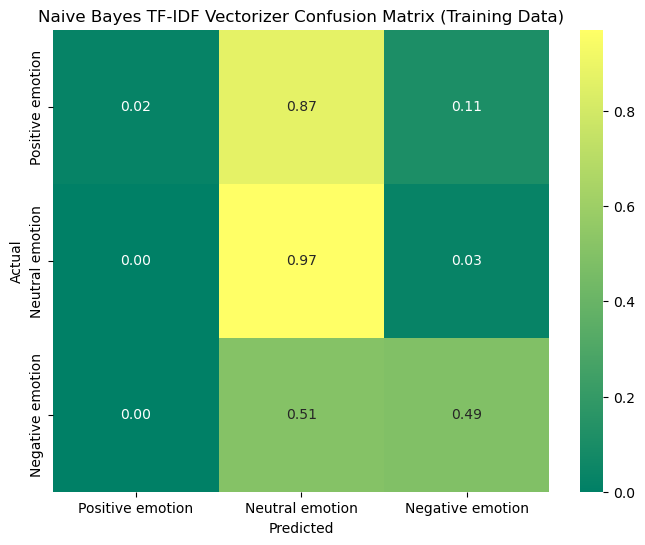


Naive Bayes TF-IDF Vectorizer Classification Report (Testing Data)
------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.29      0.23      0.25       114
 Neutral emotion       0.58      0.96      0.73       931
Negative emotion       0.92      0.02      0.04       593

        accuracy                           0.57      1638
       macro avg       0.60      0.40      0.34      1638
    weighted avg       0.69      0.57      0.44      1638



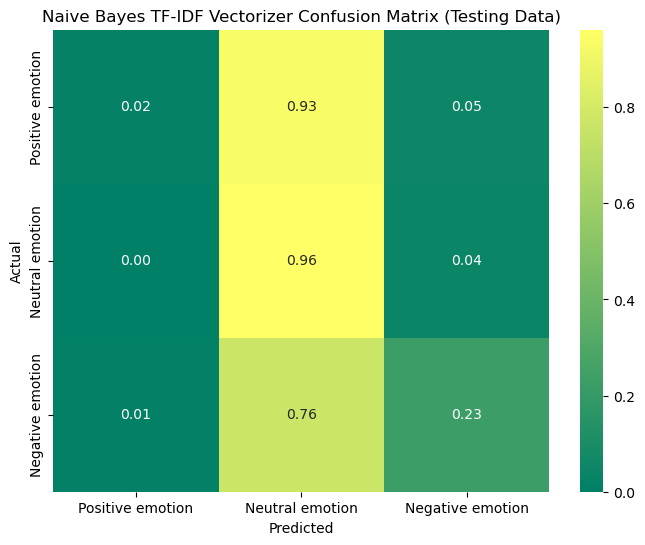

In [65]:
# trial with an arbitrary class prior
# Using TF-IDF Vectorizer

nb_model = MultinomialNB(class_prior=[0.48, 0.46, 0.06])

# Fit the model on the training data

nb_model.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(nb_model, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes TF-IDF Vectorizer')

Setting the class prior on the Naive Bayes model shows no improvement in the model performance.

##### Multinomial Naive Bayes,Count Vectorizer with SMOTE


Naive Bayes Count Vectorizer (SMOTE) Classification Report (Training Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.88      0.93      0.90      3721
 Neutral emotion       0.74      0.91      0.82      3721
Negative emotion       0.93      0.53      0.67      2372

        accuracy                           0.82      9814
       macro avg       0.85      0.79      0.80      9814
    weighted avg       0.84      0.82      0.82      9814



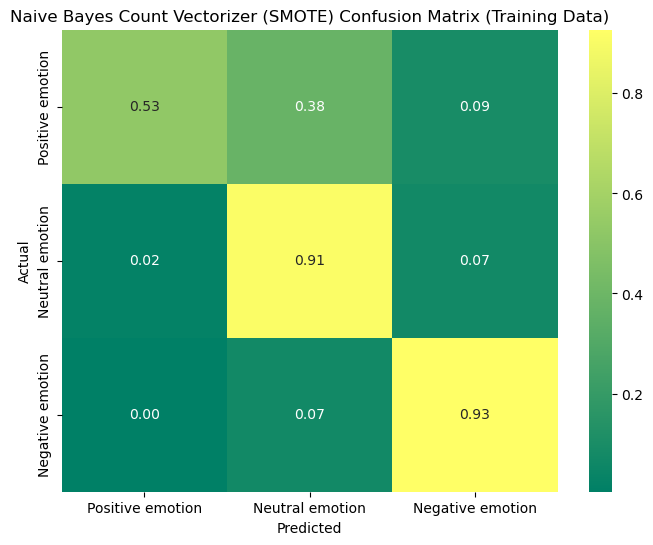


Naive Bayes Count Vectorizer (SMOTE) Classification Report (Testing Data)
-------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.26      0.44      0.32       114
 Neutral emotion       0.65      0.82      0.72       931
Negative emotion       0.73      0.32      0.45       593

        accuracy                           0.61      1638
       macro avg       0.55      0.53      0.50      1638
    weighted avg       0.65      0.61      0.60      1638



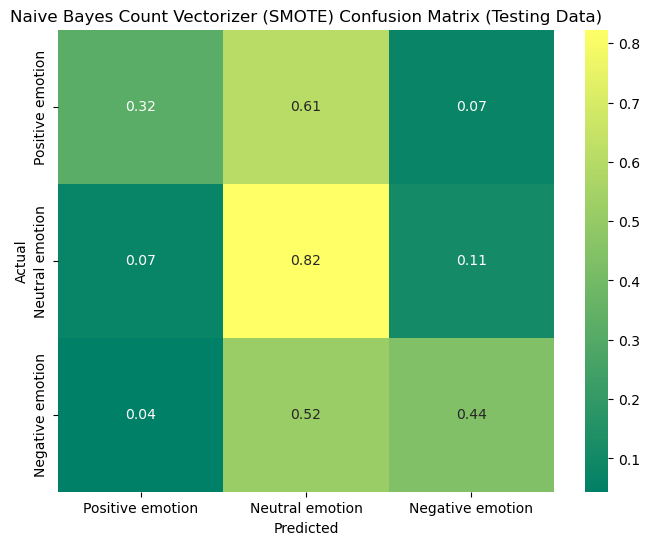

In [66]:
# Using SMOTE on the Naive Bayes model with Count Vectorizer  

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_count_combined, y_train)

# Fit the model on the resampled training data

nb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(nb_model, X_train_resampled, X_test_multinomial_count_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes Count Vectorizer (SMOTE)')

##### Multinomial Naive Bayes,TF-IDF Vectorizer with SMOTE


Naive Bayes TF-IDF Vectorizer (SMOTE) Classification Report (Training Data)
---------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.80      0.98      0.88      3721
 Neutral emotion       0.65      0.91      0.76      3721
Negative emotion       1.00      0.01      0.03      2372

        accuracy                           0.72      9814
       macro avg       0.82      0.64      0.56      9814
    weighted avg       0.79      0.72      0.63      9814



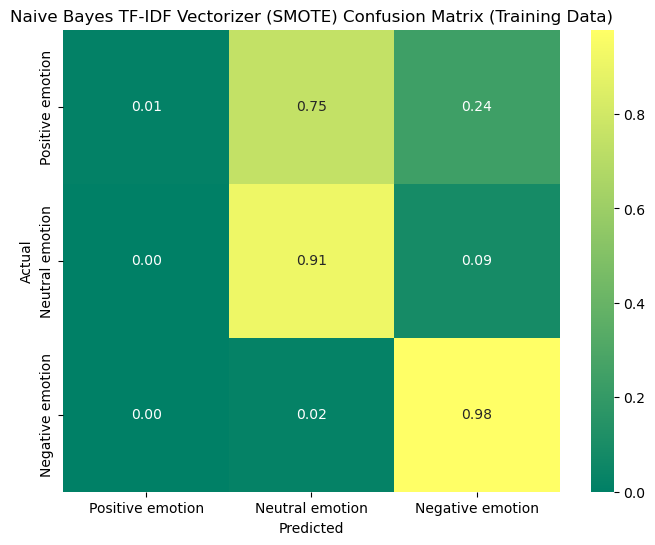


Naive Bayes TF-IDF Vectorizer (SMOTE) Classification Report (Testing Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.22      0.64      0.32       114
 Neutral emotion       0.61      0.85      0.71       931
Negative emotion       1.00      0.01      0.01       593

        accuracy                           0.53      1638
       macro avg       0.61      0.50      0.35      1638
    weighted avg       0.72      0.53      0.43      1638



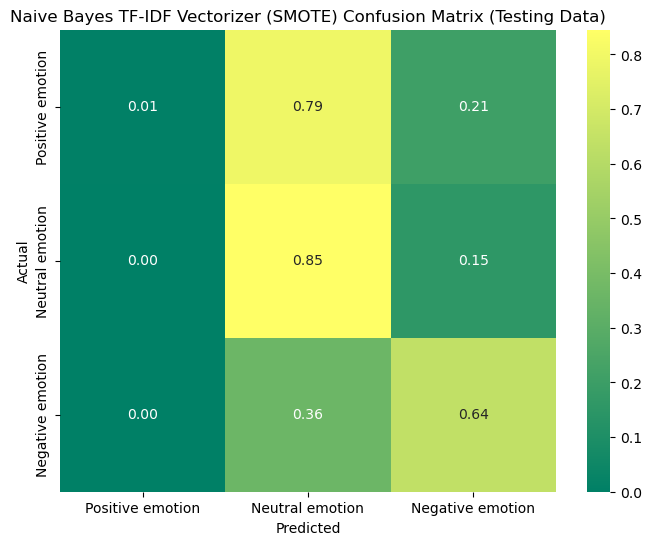

In [67]:
# Using SMOTE on the Naive Bayes model with TF-IDF Vectorizer

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_tfidf_combined, y_train)

# Fit the model on the resampled training data

nb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(nb_model, X_train_resampled, X_test_multinomial_tfidf_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes TF-IDF Vectorizer (SMOTE)')

Using SMOTE negatively affects the model performance leading to reduced accuracy scores

##### Grid Search Multinomial Naive Bayes with SMOTE or without and either Count Vectorizer TF-IDF Vectorizer

In [68]:
# Using GridSearchCV to tune the hyperparameters of the Naive Bayes model with Count Vectorizer

pipeline = Pipeline([
    ('model', MultinomialNB())
])

# Define the hyperparameters to tune

param_grid = {
    'model__alpha': [0.1, 0.5,1,2,5, 10],
    'model__fit_prior': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train_multinomial_count_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'model__alpha': 0.5, 'model__fit_prior': True}
Best F1 Score: 0.527506126005375



Naive Bayes Count Vectorizer Classification Report (Training Data)
------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.76      0.68      0.72       455
 Neutral emotion       0.87      0.88      0.87      3721
Negative emotion       0.82      0.82      0.82      2372

        accuracy                           0.84      6548
       macro avg       0.82      0.79      0.80      6548
    weighted avg       0.84      0.84      0.84      6548



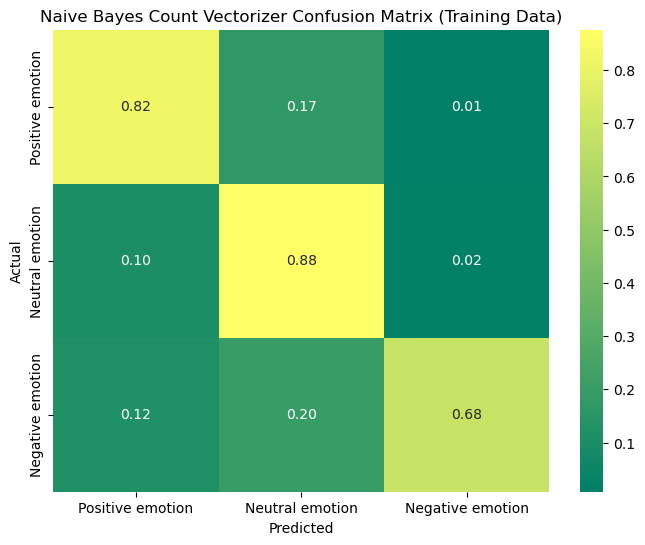


Naive Bayes Count Vectorizer Classification Report (Testing Data)
-----------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.48      0.31      0.37       114
 Neutral emotion       0.70      0.73      0.72       931
Negative emotion       0.59      0.60      0.59       593

        accuracy                           0.65      1638
       macro avg       0.59      0.54      0.56      1638
    weighted avg       0.65      0.65      0.65      1638



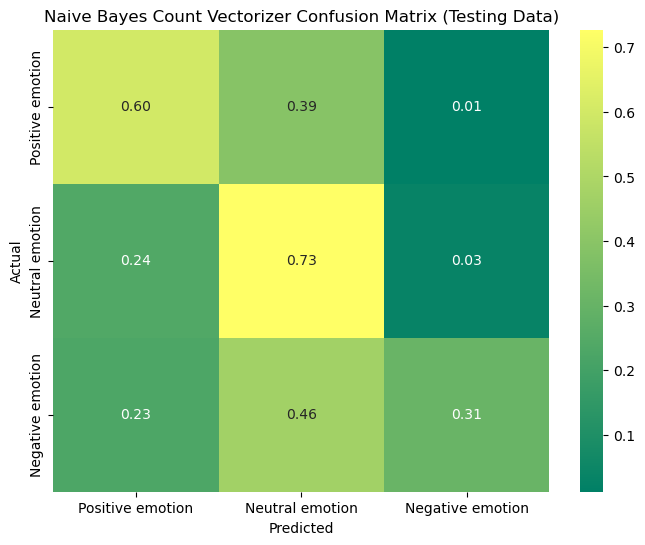

In [69]:
nb_model = MultinomialNB(alpha=0.5, fit_prior=True)

# Fit the model on the training data

nb_model.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model

evaluate_model(nb_model, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes Count Vectorizer')

In [70]:
# Using GridSearchCV to tune the hyperparameters of the Naive Bayes model with TF-IDF Vectorizer

pipeline = Pipeline([
    ('model', MultinomialNB())
])

# Define the hyperparameters to tune

param_grid = {
    'model__alpha': [0.1, 0.5,1,2,5, 10],
    'model__fit_prior': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train_multinomial_tfidf_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'model__alpha': 0.1, 'model__fit_prior': True}
Best F1 Score: 0.5229617802511856



Naive Bayes TF-IDF Vectorizer Classification Report (Training Data)
-------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.93      0.66      0.77       455
 Neutral emotion       0.86      0.94      0.90      3721
Negative emotion       0.88      0.81      0.84      2372

        accuracy                           0.87      6548
       macro avg       0.89      0.80      0.84      6548
    weighted avg       0.87      0.87      0.87      6548



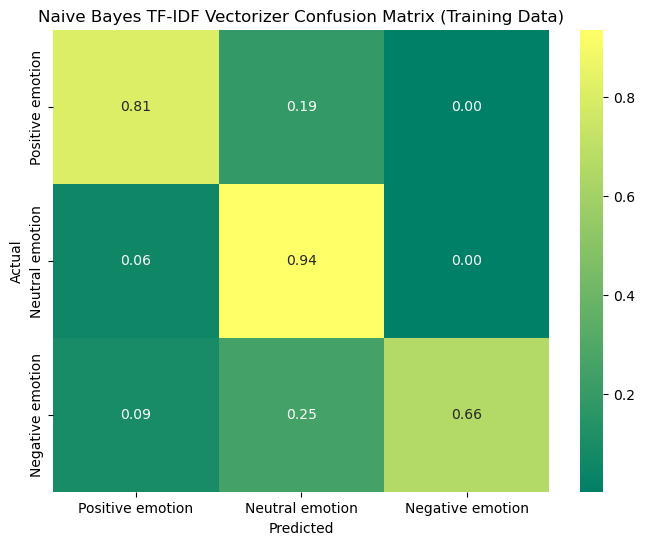


Naive Bayes TF-IDF Vectorizer Classification Report (Testing Data)
------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.66      0.22      0.33       114
 Neutral emotion       0.68      0.78      0.73       931
Negative emotion       0.60      0.53      0.57       593

        accuracy                           0.65      1638
       macro avg       0.65      0.51      0.54      1638
    weighted avg       0.65      0.65      0.64      1638



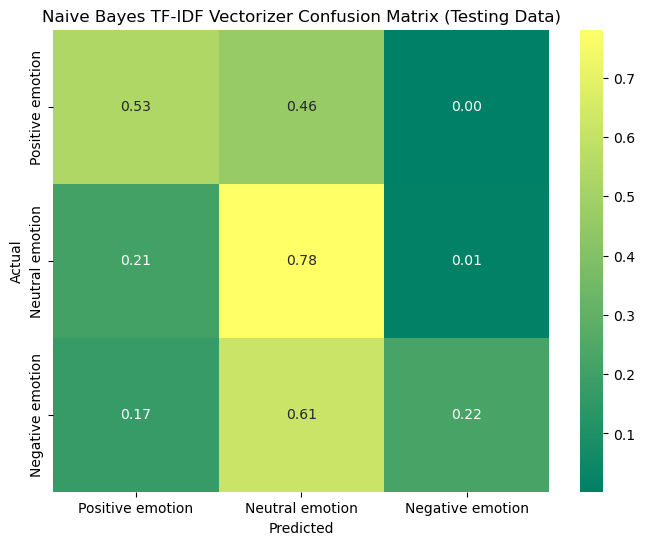

In [71]:
nb_model = MultinomialNB(alpha=0.1, fit_prior=True)

# Fit the model on the training data

nb_model.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(nb_model, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes TF-IDF Vectorizer')



Tuning the hyperparameters of the model using Grid Search has slightly improved in the model performance.

In [72]:
# Using GridSearchCV to tune the hyperparameters of the Naive Bayes model with Count Vectorizer

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', MultinomialNB())
])

# Define the hyperparameters to tune

param_grid = {
    'smote__sampling_strategy': ['minority', 'not minority'],
    'model__alpha': [0.1, 0.5,1,2,5, 10],
    'model__fit_prior': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train_multinomial_count_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'model__alpha': 2, 'model__fit_prior': False, 'smote__sampling_strategy': 'minority'}
Best F1 Score: 0.5242970622930193



Naive Bayes Count Vectorizer (SMOTE) Classification Report (Training Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.91      0.85      0.88      3721
 Neutral emotion       0.75      0.83      0.79      3721
Negative emotion       0.78      0.73      0.75      2372

        accuracy                           0.81      9814
       macro avg       0.81      0.80      0.81      9814
    weighted avg       0.82      0.81      0.81      9814



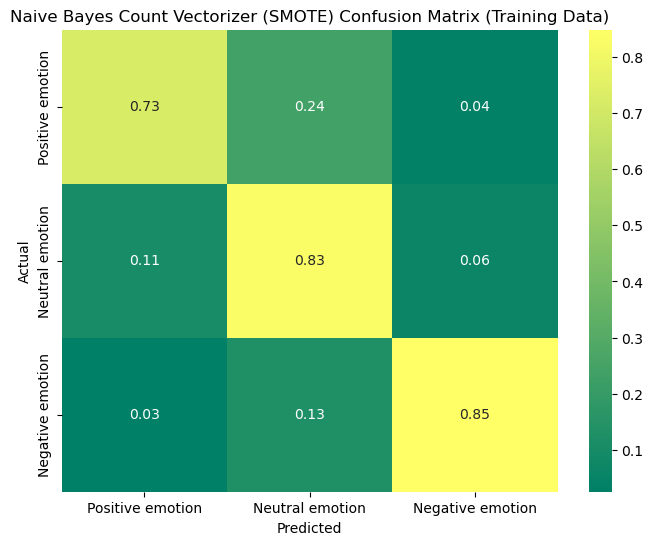


Naive Bayes Count Vectorizer (SMOTE) Classification Report (Testing Data)
-------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.29      0.33      0.31       114
 Neutral emotion       0.69      0.72      0.71       931
Negative emotion       0.59      0.54      0.56       593

        accuracy                           0.63      1638
       macro avg       0.52      0.53      0.53      1638
    weighted avg       0.63      0.63      0.63      1638



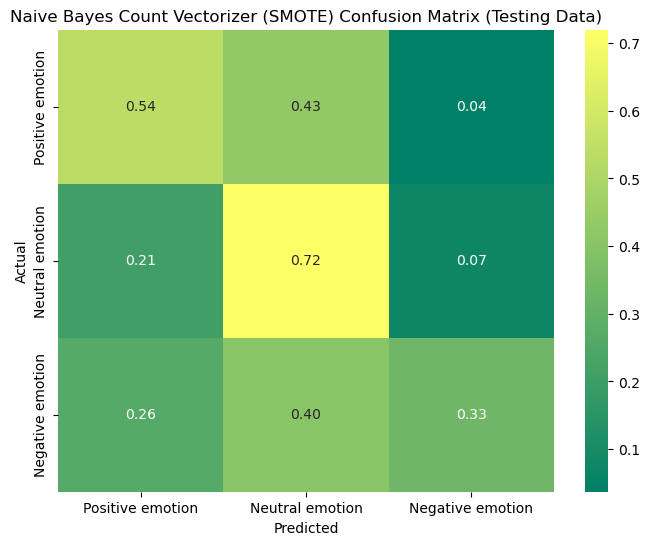

In [73]:
nb_model = MultinomialNB(alpha=2, fit_prior=False)

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_count_combined, y_train)
# Fit the model on the training data

nb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(nb_model, X_train_resampled, X_test_multinomial_count_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes Count Vectorizer (SMOTE)')


In [74]:
# Using GridSearchCV to tune the hyperparameters of the Naive Bayes model with TF-IDF Vectorizer

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', MultinomialNB())
])

# Define the hyperparameters to tune

param_grid = {
    'smote__sampling_strategy': ['minority', 'not minority'],
    'model__alpha': [0.1, 0.5,1,2,5, 10],
    'model__fit_prior': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train_multinomial_tfidf_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'model__alpha': 0.5, 'model__fit_prior': False, 'smote__sampling_strategy': 'minority'}
Best F1 Score: 0.5323314740478066



Naive Bayes TF-IDF Vectorizer (SMOTE) Classification Report (Training Data)
---------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.92      0.98      0.95      3721
 Neutral emotion       0.87      0.83      0.85      3721
Negative emotion       0.83      0.79      0.81      2372

        accuracy                           0.88      9814
       macro avg       0.87      0.87      0.87      9814
    weighted avg       0.88      0.88      0.88      9814



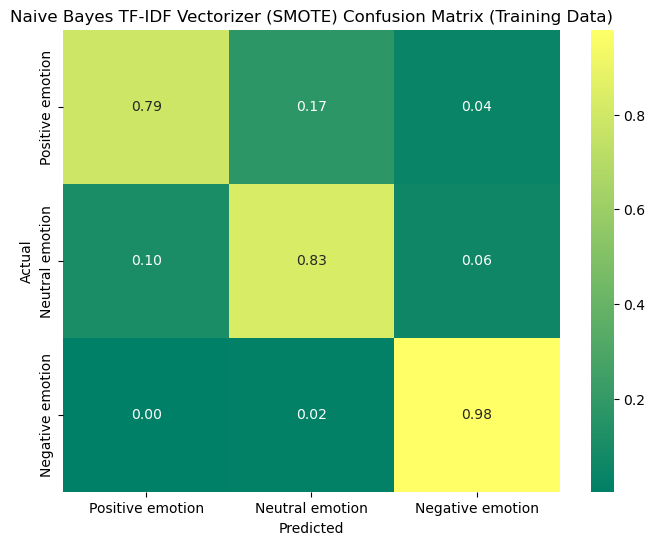


Naive Bayes TF-IDF Vectorizer (SMOTE) Classification Report (Testing Data)
--------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.30      0.54      0.39       114
 Neutral emotion       0.70      0.66      0.68       931
Negative emotion       0.58      0.55      0.56       593

        accuracy                           0.61      1638
       macro avg       0.53      0.58      0.54      1638
    weighted avg       0.63      0.61      0.62      1638



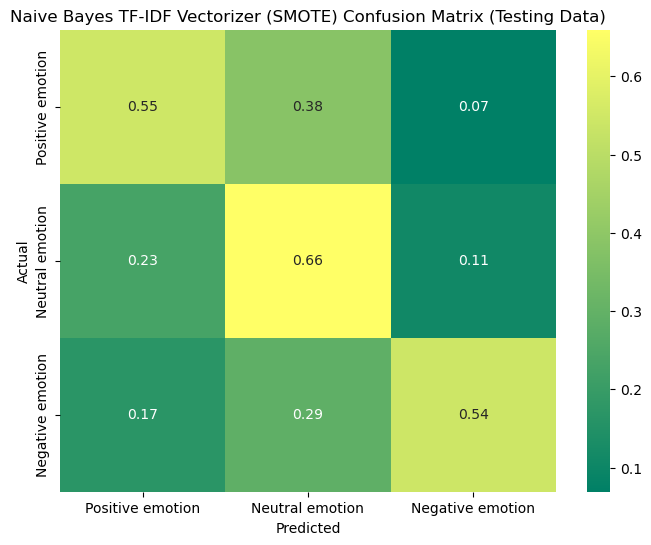

In [75]:

nb_model = MultinomialNB(alpha=0.5, fit_prior=False)

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_tfidf_combined, y_train)

# Fit the model on the training data

nb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(nb_model, X_train_resampled, X_test_multinomial_tfidf_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Naive Bayes TF-IDF Vectorizer (SMOTE)')



 Using SMOTE with the tuned hyperparameters has improved the model performance but still the model shows a bias on neutral sentiment

##### Best Naive Bayes Model

In [76]:
# storing the best perfomance naives bayes on our performance dataframe

naive_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('model', MultinomialNB(alpha=0.5, fit_prior=False))
])


model_performance(naive_pipeline, X_train_multinomial_tfidf_combined, y_train,  label='Naive Bayes TF-IDF Vectorizer (SMOTE)')

Model  Average F1 Score  \
0  Logistic Regression TF-IDF Vectorizer (SMOTE)            0.6512   
1          Naive Bayes TF-IDF Vectorizer (SMOTE)            0.6170   

   Average ROC AUC Score  Standard Deviation of ROC AUC Score  
0                 0.7519                               0.0064  
1                 0.7219                               0.0097

#### Random Forest

##### Random Forest,Count Vectorizer


Random Forest Count Vectorizer Classification Report (Training Data)
--------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.98      0.94      0.96       455
 Neutral emotion       0.95      0.98      0.96      3721
Negative emotion       0.97      0.93      0.95      2372

        accuracy                           0.96      6548
       macro avg       0.96      0.95      0.96      6548
    weighted avg       0.96      0.96      0.96      6548



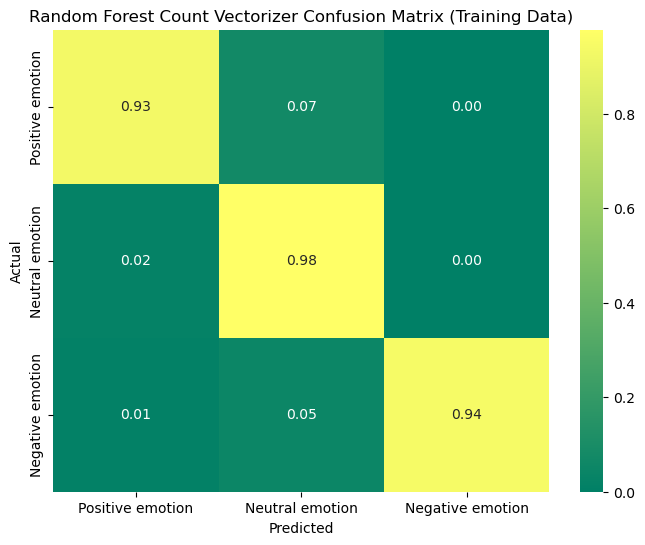


Random Forest Count Vectorizer Classification Report (Testing Data)
-------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.70      0.23      0.34       114
 Neutral emotion       0.68      0.85      0.76       931
Negative emotion       0.68      0.49      0.57       593

        accuracy                           0.68      1638
       macro avg       0.69      0.52      0.56      1638
    weighted avg       0.68      0.68      0.66      1638



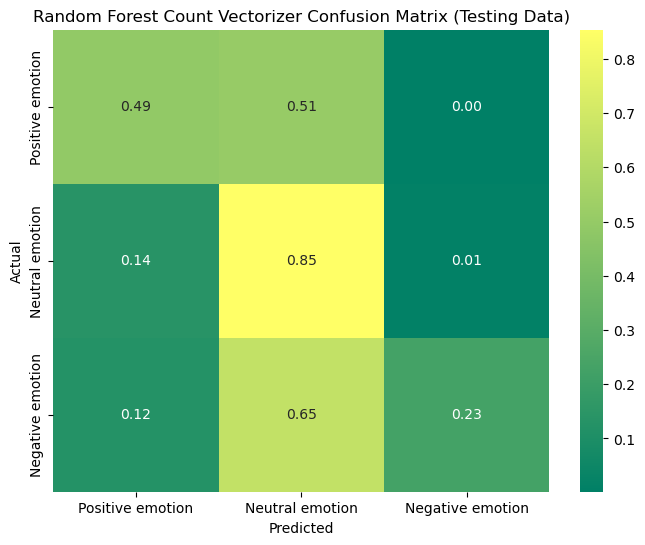

In [77]:
# Using count vectorizer
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model

evaluate_model(rf_model, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Random Forest Count Vectorizer')

##### Random Forest,TF-IDF Vectorizer


Random Forest TF-IDF Vectorizer Classification Report (Training Data)
---------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.99      0.93      0.96       455
 Neutral emotion       0.95      0.98      0.96      3721
Negative emotion       0.96      0.93      0.95      2372

        accuracy                           0.96      6548
       macro avg       0.97      0.95      0.96      6548
    weighted avg       0.96      0.96      0.96      6548



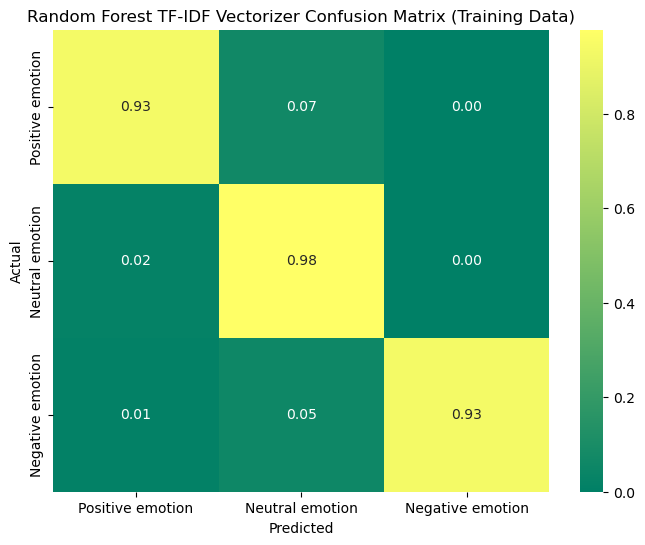


Random Forest TF-IDF Vectorizer Classification Report (Testing Data)
--------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.67      0.19      0.30       114
 Neutral emotion       0.67      0.84      0.75       931
Negative emotion       0.66      0.49      0.56       593

        accuracy                           0.67      1638
       macro avg       0.67      0.51      0.54      1638
    weighted avg       0.67      0.67      0.65      1638



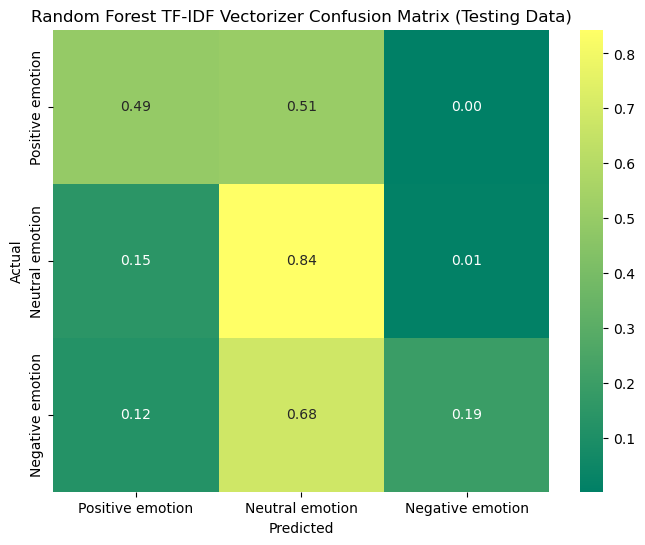

In [78]:
# using TF-IDF Vectorizer

rf_model = RandomForestClassifier(random_state=42)
# fit the model
rf_model.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(rf_model, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Random Forest TF-IDF Vectorizer')


Random Forest model has improved on the recall score compared to the Naive Bayes model and has better accuracy scores than both the Logistic Regression and Naive Bayes models.

##### Random Forest,count vectorizer,SMOTE


Random Forest Count Vectorizer (SMOTE) Classification Report (Training Data)
----------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.99      0.99      0.99      3721
 Neutral emotion       0.95      0.97      0.96      3721
Negative emotion       0.96      0.93      0.95      2372

        accuracy                           0.97      9814
       macro avg       0.97      0.96      0.97      9814
    weighted avg       0.97      0.97      0.97      9814



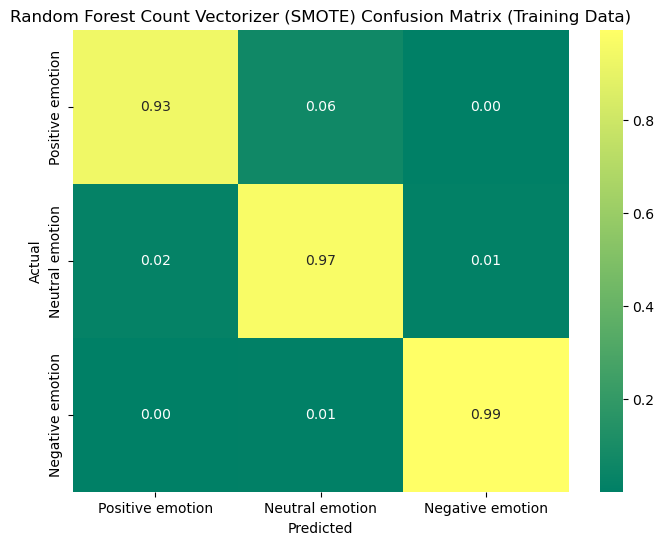


Random Forest Count Vectorizer (SMOTE) Classification Report (Testing Data)
---------------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.19      0.54      0.29       114
 Neutral emotion       0.69      0.69      0.69       931
Negative emotion       0.68      0.45      0.54       593

        accuracy                           0.59      1638
       macro avg       0.52      0.56      0.51      1638
    weighted avg       0.65      0.59      0.61      1638



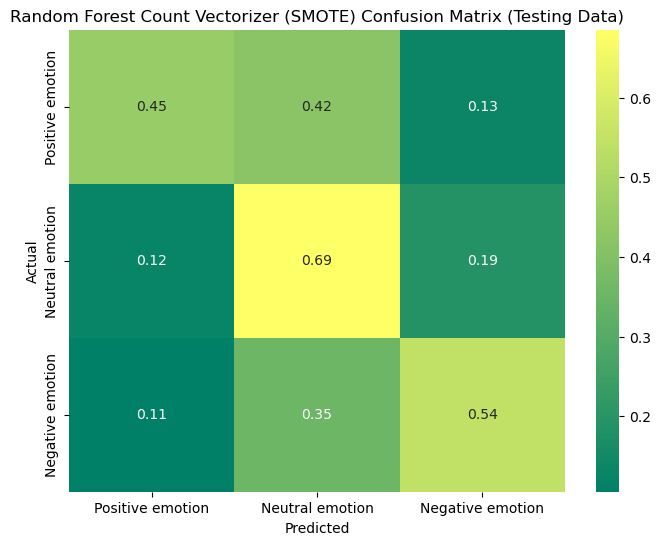

In [79]:
# Using SMOTE on the Random Forest model with Count Vectorizer to handle class imbalance

smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the training data only

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_multinomial_count_combined, y_train)

# Fit the model on the resampled training data

rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model

evaluate_model(rf_model, X_train_resampled, X_test_multinomial_count_combined, y_train_resampled, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Random Forest Count Vectorizer (SMOTE)')

SMOTE seems to greatly affect the model performance negatively. We will continue to use the Random Forest model without SMOTE.

##### GRID SEARCH Random Forest with either Count Vectorizer or TF-IDF Vectorizer

In [80]:
# Using gridsearchcv to tune the hyperparameters of the Random Forest model with Count Vectorizer

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Define the hyperparameters to tune

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train_multinomial_count_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best hyperparameters: {'model__class_weight': 'balanced_subsample', 'model__max_depth': 50, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best F1 Score: 0.5380142272371674


In [81]:
# using tfidf vectorizer and gridsearchcv to tune the hyperparameters of the Random Forest model

pipeline = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Define the hyperparameters to tune

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')

grid_search.fit(X_train_multinomial_tfidf_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best hyperparameters: {'model__class_weight': 'balanced', 'model__max_depth': 50, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best F1 Score: 0.5342319193374302



Random Forest Count Vectorizer Classification Report (Training Data)
--------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.79      0.93      0.86       455
 Neutral emotion       0.90      0.86      0.88      3721
Negative emotion       0.82      0.85      0.83      2372

        accuracy                           0.86      6548
       macro avg       0.84      0.88      0.85      6548
    weighted avg       0.86      0.86      0.86      6548



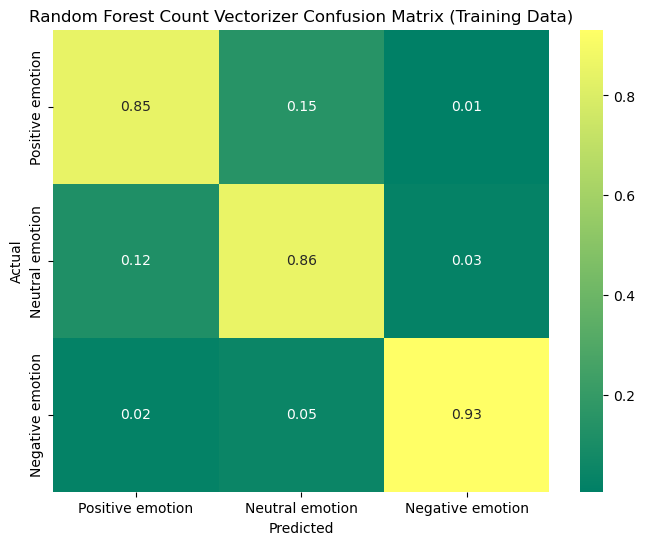


Random Forest Count Vectorizer Classification Report (Testing Data)
-------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.46      0.45      0.45       114
 Neutral emotion       0.72      0.70      0.71       931
Negative emotion       0.58      0.61      0.59       593

        accuracy                           0.65      1638
       macro avg       0.59      0.58      0.58      1638
    weighted avg       0.65      0.65      0.65      1638



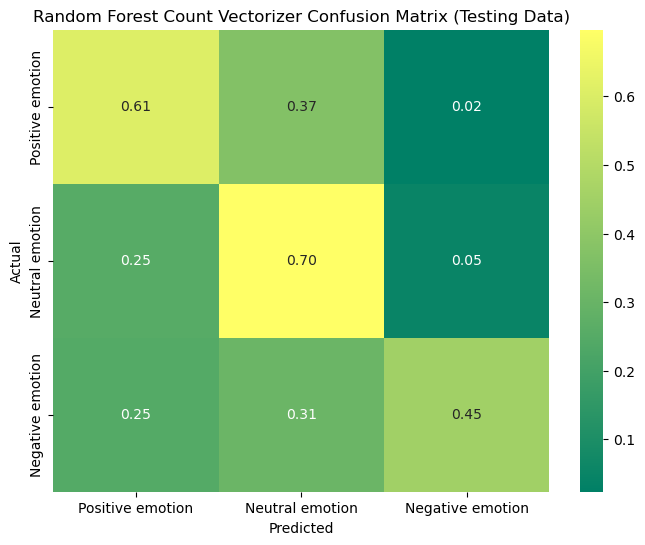

In [82]:
# evaluating the best performing random forest model of count vectorizer

rf_model = RandomForestClassifier(class_weight='balanced_subsample', max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42)

# Fit the model on the training data

rf_model.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model

evaluate_model(rf_model, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Random Forest Count Vectorizer')


Random Forest TF-IDF Vectorizer Classification Report (Training Data)
---------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.80      0.98      0.88       455
 Neutral emotion       0.92      0.89      0.91      3721
Negative emotion       0.86      0.88      0.87      2372

        accuracy                           0.89      6548
       macro avg       0.86      0.91      0.89      6548
    weighted avg       0.89      0.89      0.89      6548



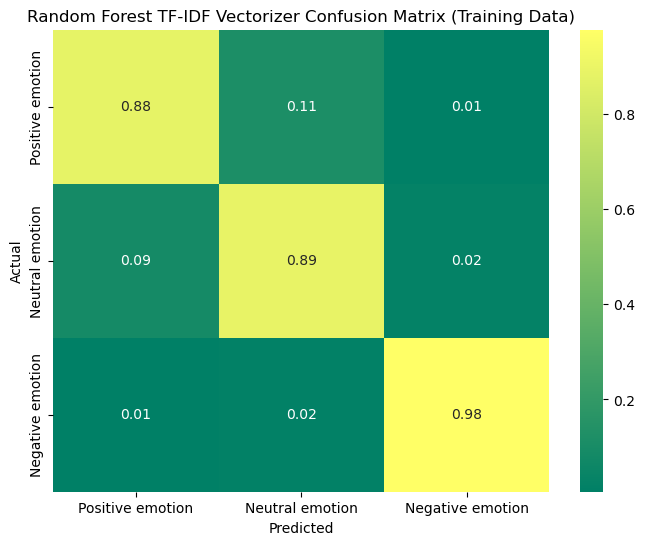


Random Forest TF-IDF Vectorizer Classification Report (Testing Data)
--------------------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.42      0.39      0.41       114
 Neutral emotion       0.72      0.68      0.70       931
Negative emotion       0.57      0.62      0.59       593

        accuracy                           0.64      1638
       macro avg       0.57      0.56      0.57      1638
    weighted avg       0.64      0.64      0.64      1638



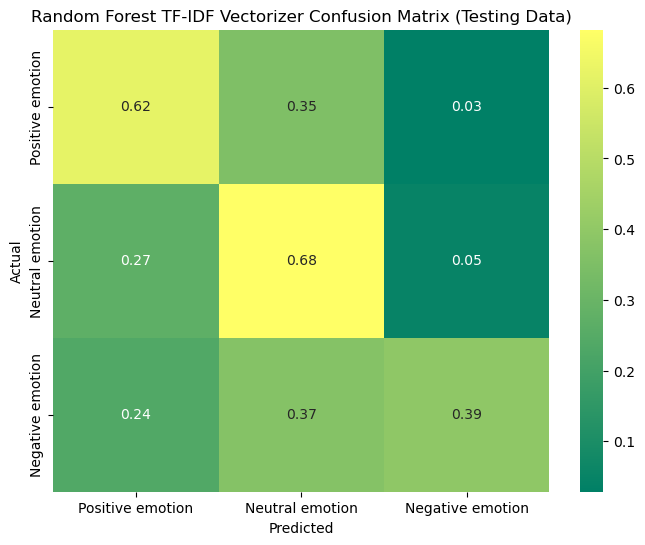

In [83]:
rf_model = RandomForestClassifier(class_weight='balanced', max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=42)

# Fit the model on the training data

rf_model.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(rf_model, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='Random Forest TF-IDF Vectorizer')

Random Forest model with Grid Search has decreased the accuracy score but has improved the overall f1 score of the model. Though the model performs better while using count vectorizer

##### Best Random Forest Model

In [84]:
# posting the best performance model to our performance df

random_forest_pipeline = Pipeline([
    ('model', RandomForestClassifier(class_weight='balanced_subsample', max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42))
])

model_performance(random_forest_pipeline, X_train_multinomial_count_combined, y_train, label='Random Forest Count Vectorizer', cv = 3)

Model  Average F1 Score  \
0  Logistic Regression TF-IDF Vectorizer (SMOTE)            0.6512   
1          Naive Bayes TF-IDF Vectorizer (SMOTE)            0.6170   
2                 Random Forest Count Vectorizer            0.6309   

   Average ROC AUC Score  Standard Deviation of ROC AUC Score  
0                 0.7519                               0.0064  
1                 0.7219                               0.0097  
2                 0.7109                               0.0033

#### Support Vector Machines

##### Support Vector Machines,Count Vectorizer


SVC Count Vectorizer Classification Report (Training Data)
----------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.83      0.99      0.90       455
 Neutral emotion       0.90      0.86      0.88      3721
Negative emotion       0.83      0.85      0.84      2372

        accuracy                           0.87      6548
       macro avg       0.85      0.90      0.88      6548
    weighted avg       0.87      0.87      0.87      6548



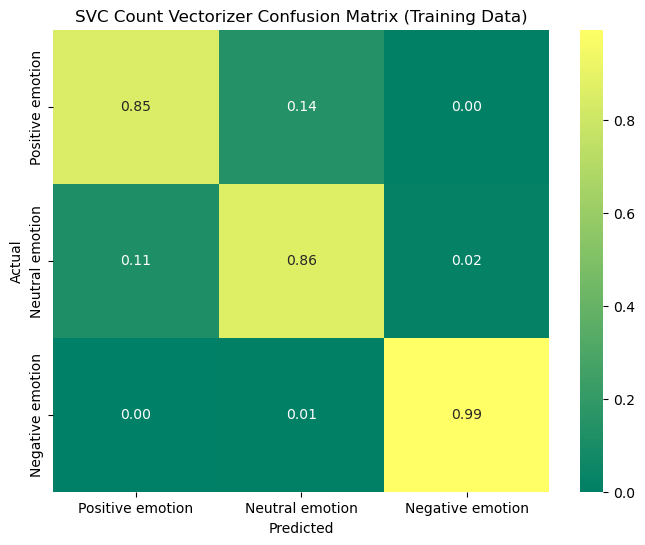


SVC Count Vectorizer Classification Report (Testing Data)
---------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.48      0.35      0.40       114
 Neutral emotion       0.71      0.73      0.72       931
Negative emotion       0.61      0.62      0.61       593

        accuracy                           0.66      1638
       macro avg       0.60      0.56      0.58      1638
    weighted avg       0.66      0.66      0.66      1638



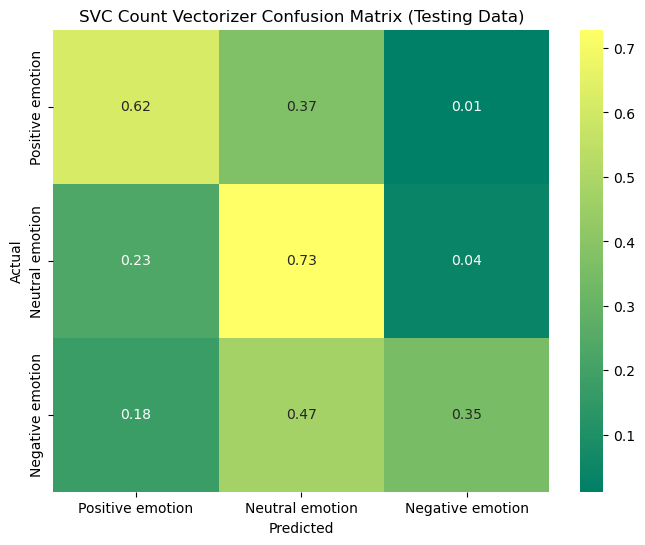

In [85]:

# Using Count Vectorizer

svc= SVC(random_state=42, class_weight='balanced')

# Fit the model on the training data

svc.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model

evaluate_model(svc, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='SVC Count Vectorizer')


##### Support Vector Machines,TF-IDF Vectorizer


SVC TF-IDF Vectorizer Classification Report (Training Data)
-----------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.84      1.00      0.91       455
 Neutral emotion       0.93      0.89      0.91      3721
Negative emotion       0.87      0.88      0.87      2372

        accuracy                           0.90      6548
       macro avg       0.88      0.92      0.90      6548
    weighted avg       0.90      0.90      0.90      6548



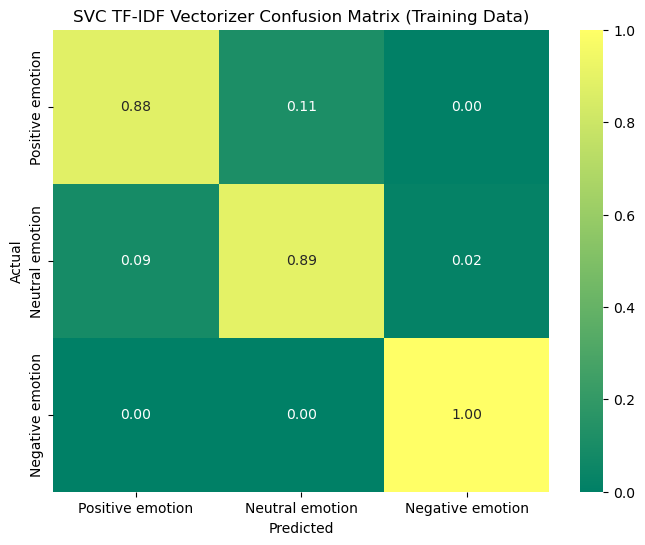


SVC TF-IDF Vectorizer Classification Report (Testing Data)
----------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.53      0.34      0.41       114
 Neutral emotion       0.71      0.72      0.71       931
Negative emotion       0.59      0.61      0.60       593

        accuracy                           0.65      1638
       macro avg       0.61      0.56      0.58      1638
    weighted avg       0.65      0.65      0.65      1638



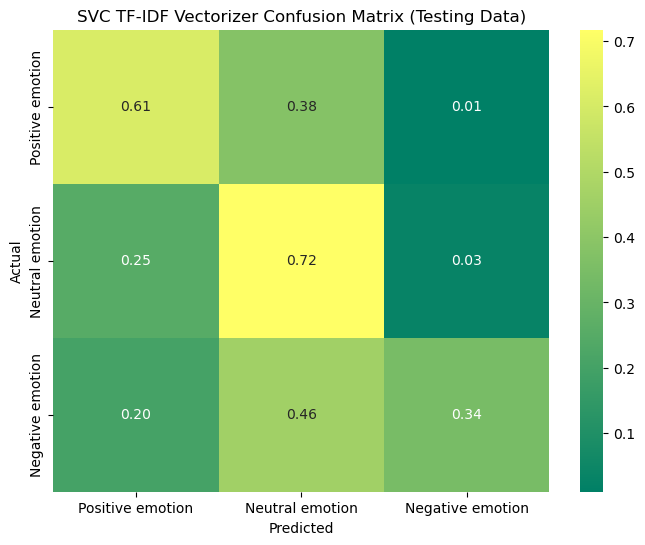

In [86]:
# Using TF-IDF Vectorizer

svc = SVC(random_state=42, class_weight='balanced')

# Fit the model on the training data

svc.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(svc, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='SVC TF-IDF Vectorizer')

##### Grid Search Support Vector Machines with either Count Vectorizer or TF-IDF Vectorizer

In [87]:
# Grid Search

# Count Vectorizer

pipeline = Pipeline([
    ('model', SVC(random_state=42, class_weight='balanced'))
])

# Define the hyperparameters to tune
  
params_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto'],
              'C': [0.1, 1, 10]}

# create grid search 
grid_svc = GridSearchCV(svc, params_grid, cv=3)

# fit the model

grid_svc.fit(X_train_multinomial_count_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_svc.best_params_}") 
print(f"Best F1 Score: {grid_svc.best_score_}")

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score: 0.6479845440680626


In [88]:
# Grid Search
# TF-IDF Vectorizer

pipeline = Pipeline([
    ('model', SVC(random_state=42, class_weight='balanced'))
])

# Define the hyperparameters to tune
  
params_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto'],
              'C': [0.1, 1, 10]}

# create grid search 
grid_svc = GridSearchCV(svc, params_grid, cv=3)

# fit the model

grid_svc.fit(X_train_multinomial_tfidf_combined, y_train)

# Display the best hyperparameters

print(f"Best hyperparameters: {grid_svc.best_params_}") 
print(f"Best F1 Score: {grid_svc.best_score_}")


Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score: 0.6482911238538948



SVC Count Vectorizer Classification Report (Training Data)
----------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.90      1.00      0.95       455
 Neutral emotion       0.98      0.93      0.96      3721
Negative emotion       0.92      0.97      0.94      2372

        accuracy                           0.95      6548
       macro avg       0.93      0.97      0.95      6548
    weighted avg       0.95      0.95      0.95      6548



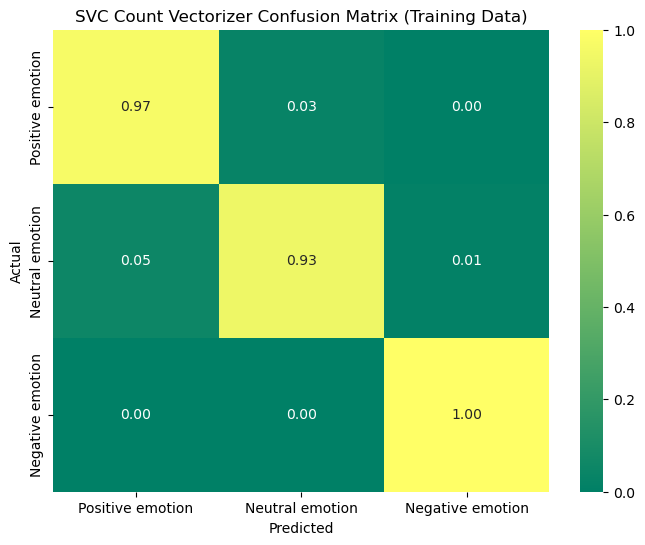


SVC Count Vectorizer Classification Report (Testing Data)
---------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.59      0.32      0.41       114
 Neutral emotion       0.71      0.76      0.73       931
Negative emotion       0.61      0.60      0.60       593

        accuracy                           0.67      1638
       macro avg       0.64      0.56      0.58      1638
    weighted avg       0.66      0.67      0.66      1638



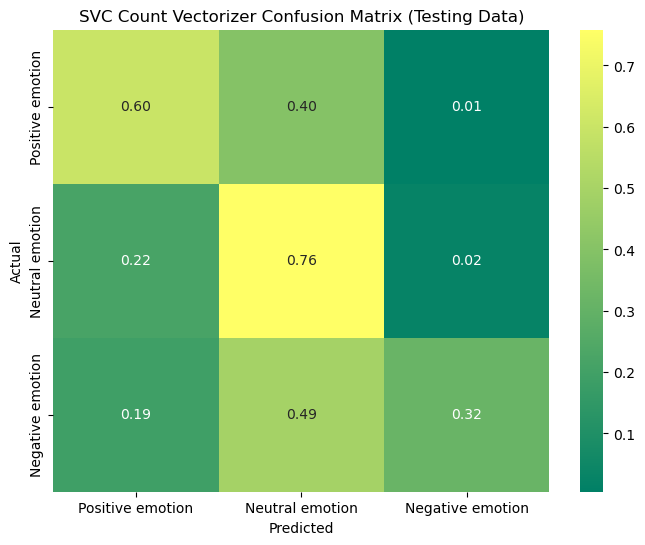

In [89]:
svc = SVC(C= 10,kernel='rbf', gamma='scale', random_state=42, class_weight='balanced')

# Fit the model on the training data

svc.fit(X_train_multinomial_count_combined, y_train)

# Evaluate the model

evaluate_model(svc, X_train_multinomial_count_combined, X_test_multinomial_count_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='SVC Count Vectorizer')


SVC TF-IDF Vectorizer Classification Report (Training Data)
-----------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.90      1.00      0.95       455
 Neutral emotion       0.98      0.94      0.96      3721
Negative emotion       0.92      0.97      0.94      2372

        accuracy                           0.95      6548
       macro avg       0.93      0.97      0.95      6548
    weighted avg       0.95      0.95      0.95      6548



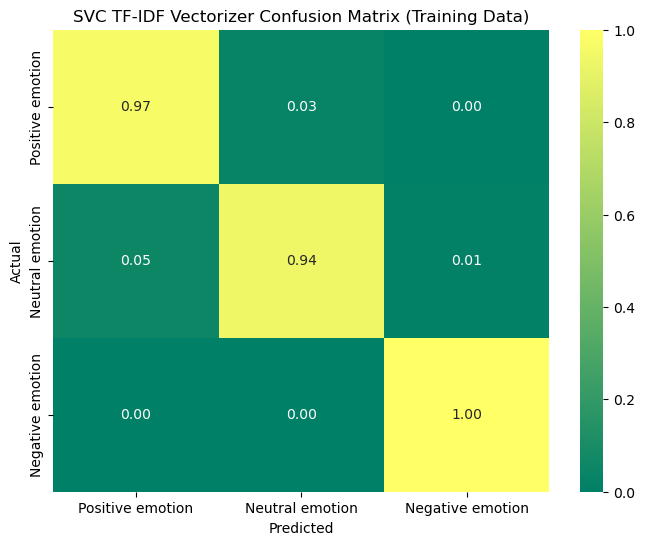


SVC TF-IDF Vectorizer Classification Report (Testing Data)
----------------------------------------------------------
                  precision    recall  f1-score   support

Positive emotion       0.60      0.28      0.38       114
 Neutral emotion       0.70      0.76      0.73       931
Negative emotion       0.62      0.60      0.61       593

        accuracy                           0.67      1638
       macro avg       0.64      0.55      0.58      1638
    weighted avg       0.67      0.67      0.66      1638



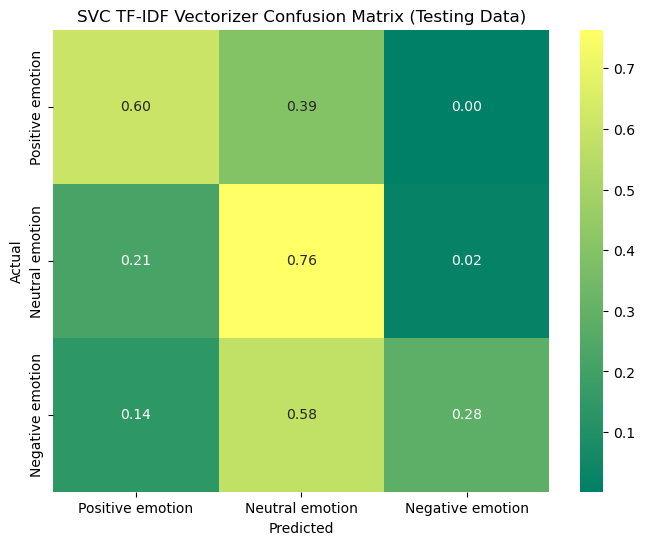

In [90]:
svc = SVC(C= 10, kernel='rbf', gamma='scale', random_state=42, class_weight='balanced')

# Fit the model on the training data

svc.fit(X_train_multinomial_tfidf_combined, y_train)

# Evaluate the model

evaluate_model(svc, X_train_multinomial_tfidf_combined, X_test_multinomial_tfidf_combined, y_train, y_test, classes=['Positive emotion', 'Neutral emotion', 'Negative emotion'], label='SVC TF-IDF Vectorizer')


Both models have good accuracy scores but are have problems with identifying positive sentiment from test data.

##### Best SVM Model

In [91]:
# Posting the best performing model to our performance dataframe will posy both due to their similar performance

svc_tfidf_pipeline = Pipeline([
    ('model', SVC(C= 10,probability= True, kernel='rbf', gamma='scale', random_state=42, class_weight='balanced'))
])

model_performance(svc_tfidf_pipeline, X_train_multinomial_tfidf_combined, y_train, label='SVC TF-IDF Vectorizer', cv = 3)

Model  Average F1 Score  \
0  Logistic Regression TF-IDF Vectorizer (SMOTE)            0.6512   
1          Naive Bayes TF-IDF Vectorizer (SMOTE)            0.6170   
2                 Random Forest Count Vectorizer            0.6309   
3                          SVC TF-IDF Vectorizer            0.6341   

   Average ROC AUC Score  Standard Deviation of ROC AUC Score  
0                 0.7519                               0.0064  
1                 0.7219                               0.0097  
2                 0.7109                               0.0033  
3                 0.7294                               0.0039

In [92]:
svc_count_pipeline = Pipeline([
    ('model', SVC(C= 10,probability= True,kernel='rbf', gamma='scale', random_state=42, class_weight='balanced'))
])

performance_df = model_performance(svc_count_pipeline, X_train_multinomial_count_combined, y_train, label='SVC Count Vectorizer', cv = 3)

### Model Evaluation

In [93]:
performance_df

Model  Average F1 Score  \
0  Logistic Regression TF-IDF Vectorizer (SMOTE)            0.6512   
1          Naive Bayes TF-IDF Vectorizer (SMOTE)            0.6170   
2                 Random Forest Count Vectorizer            0.6309   
3                          SVC TF-IDF Vectorizer            0.6341   
4                           SVC Count Vectorizer            0.6366   

   Average ROC AUC Score  Standard Deviation of ROC AUC Score  
0                 0.7519                               0.0064  
1                 0.7219                               0.0097  
2                 0.7109                               0.0033  
3                 0.7294                               0.0039  
4                 0.7271                               0.0064

#### **INSIGHTS**

This evaluation compared several models on a dataset containing tweets targeting two brands (Apple and Google) with three sentiment classes: positive, negative, and neutral. The dataset exhibited class imbalance, and most models struggled to differentiate between positive and neutral sentiments due to the similarity in the vocabulary used for these two classes. Above is a summary of the results and an explanation of the metrics used.


**BEST MODEL**

The __Logistic Regression model with TF-IDF Vectorizer and SMOTE__ emerged as the best-performing model:

1) __F1 Score: 0.6512__, the highest among all models, indicating a better balance between precision and recall.
2) __ROC AUC Score: 0.7519__, the highest separability score across classes.
3) __Standard Deviation of ROC AUC: 0.0064__, showing relatively consistent performance across folds.

This model benefited from the use of:

1) __TF-IDF Vectorizer:__ Which prioritized distinguishing terms based on importance.
2) __SMOTE:__ Which addressed the class imbalance by oversampling the minority class.

**Limitations**
- Despite its overall performance, the model faced difficulty in distinguishing positive and neutral sentiments, likely due to overlapping vocabulary in tweets related to these sentiments.

**Explanation of Metrics**

1) __Average F1 Score:__ 
- The F1 Score is the harmonic mean of precision (how many predicted positives are correct) and recall (how many actual positives are correctly identified).

- It is particularly useful in imbalanced datasets, as it balances the trade-off between false positives and false negatives.

2) __Average ROC AUC Score:__ 
- The Area Under the Receiver Operating Characteristic (ROC) Curve measures the model's ability to distinguish between classes.
- A higher ROC AUC indicates better separability of classes, irrespective of threshold selection.

3) __Standard Deviation of ROC AUC:__

- Measures the variability of the ROC AUC score across cross-validation folds.
- A lower standard deviation indicates more stable performance.




#### Conclusions

The Logistic Regression model with TF-IDF Vectorizer and SMOTE is recommended as the best model for sentiment analysis on this dataset. While it achieved the highest F1 Score and ROC AUC, the presence of class imbalance and the similarity of words in positive and neutral tweets remained challenges for all models.

**Recommendations**

Based on the analysis of the sentiment dataset and the performance of multiple models, the following recommendations are provided to optimize sentiment analysis efforts for the business:

1) **Adopt the Best Performing Model**
The Logistic Regression model with TF-IDF Vectorizer and SMOTE is the most suitable for sentiment analysis due to its strong performance metrics:

- **F1 Score:** 0.6512 (indicating good balance between precision and recall).
- **ROC AUC:** 0.7519 (showing strong ability to distinguish between sentiments).
- **Consistency:** Low standard deviation of 0.0064, ensuring reliable predictions across data samples.

This model is recommended for deployment to analyze customer feedback related to Apple and Google products. Its ability to handle imbalanced data ensures that underrepresented sentiments, such as negative feedback, are not overlooked.


2. **Address Challenges with Positive and Neutral Sentiments**
The analysis revealed that all models struggled to differentiate between positive and neutral tweets. This is due to the overlap in vocabulary used in these sentiments. To address this:

- **Actionable Insights:** Review common keywords in tweets classified as positive or neutral and refine them. For example, terms like "good" and "okay" may need additional context to ensure correct classification.
- **Enhanced Data Collection:** Better classification on sentiment labels can be achieved by collecting more diverse and detailed data. This can help in distinguishing subtle differences in sentiment expressions. For example, collecting tweets with stronger emotional language can improve model performance.
- **Different Data Source:** Consider using additional data sources beyond Twitter to capture a wider range of sentiments and expressions. This can provide a more comprehensive view of customer feedback and improve sentiment analysis accuracy.


### Model Deployment

In [94]:
best_logreg = logreg_pipeline

best_logreg


Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=42))])